<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">

# EP 3 - Geração de Títulos (Bi-LSTM + Atenção)

**Nome:** Davy Alves de Souza

**Numero USP:** 11561247

## Setup

Importando bibliotecas necessárias para o desenvolvimento

In [1]:
import pandas as pd
import numpy as np

import nltk
import nltk.translate as translate
import nltk.translate.nist_score as nist_score

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import data

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [2]:
print("Verificando versões:")
print("    Tensorflow: %s" % tf.__version__)
print("        Pandas: %s" % pd.__version__)
print("         NumPy: %s" % np.version.version)
print("    MatplotLib: %s" % matplotlib.__version__)
print("          NLTK: %s" % nltk.__version__)


Verificando versões:
    Tensorflow: 2.3.1
        Pandas: 1.1.1
         NumPy: 1.18.5
    MatplotLib: 3.3.1


Configurando parametros de execução:

In [3]:
DATASET_PATH = "../data/b2w-10k.csv"

MAX_TOKENS    = 30000  # numero  maximo de tokens
OUTPUT_LEN    = 45     # tamanho da saida (pad/truc)
BATCH_SIZE    = 16     # tamanho do batch
EPOCHS        = 50     # numero de epocas

## Pré-processamento

Lendo e pré-processando **CSV**. O resultado final está no formato de um **dataframe Pandas**

In [4]:
b2w_dataframe = pd.read_csv(DATASET_PATH)

# selecting columns
processed_data = b2w_dataframe[['review_text', 'review_title']]

# dropping NaN values
processed_data = processed_data.dropna()

processed_data.head()

,review_text,review_title
0,Estou contente com a compra entrega rápida o ú...,Bom
1,"Por apenas R$1994.20,eu consegui comprar esse ...","Preço imbatível, ótima qualidade"
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,ATENDE TODAS AS EXPECTATIVA.
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,presente mais que desejado
4,"A entrega foi no prazo, as americanas estão de...","Sem duvidas, excelente"


Embaralhando e dividindo córpus em: **Treino**, **Validação** e **Teste**

In [5]:
# shuffling data
processed_data = processed_data.sample(frac=1).reset_index(drop=True)

# splitting data
validation_data_offset = int(.65 * len(processed_data))
testing_data_offset = int(.75 * len(processed_data))

processed_data['review_title'] = ['startsent ' + processed_data['review_title'][i] + ' endsent' for i in range(len(processed_data['review_title']))]

train_df, validate_df, test_df = np.split(processed_data, [validation_data_offset, testing_data_offset])

validate_df = validate_df.reset_index()
test_df = test_df.reset_index()

num_samples          = len(processed_data['review_text'])
num_train_samples    = len(train_df['review_text'])
num_validate_samples = len(validate_df['review_text'])
num_test_samples     = len(test_df['review_text'])

print("Total de amostras: %d" % num_samples)
print("Total de amostras (treino):    %d (%d%%)" % (num_train_samples, round(num_train_samples / num_samples * 100)))
print("Total de amostras (validação): %d (%d%%)" % (num_validate_samples, round(num_validate_samples / num_samples * 100)))
print("Total de amostras (teste):     %d (%d%%)" % (num_test_samples, round(num_test_samples / num_samples * 100)))

Total de amostras: 9999
Total de amostras (treino):    6499 (65%)
Total de amostras (validação): 1000 (10%)
Total de amostras (teste):     2500 (25%)


## One hot encoding

As funções abaixo serão utilizadas para a criação do *one hot encoding* dos dados do dataframe

In [6]:
# transforma string em int seguindo o vocabulário
# params: string: string a ser parseada,
#         length: tamanho max. da entrada
#          vocab: vocabulario
# retorna um array de ids
def string_to_int(string, length, vocab):
    string = string.lower() # string to lowercase
    string = string.replace(',','') # removendo virgulas
    
    arr = string.split() # string to array
        
         
    X = []
    idx = 0
    
    # enquanto houver espaço no array, preenche array com o id da palavra ou pad      
    while idx < length:
        # se palavra ja terminou, adiciona pad
        if idx >= len(arr):
            X.append(vocab[''])
        else:
            # adiciona id da palavra ou [UNK] para palavras desconhecidas
            if arr[idx] in vocab:
                X.append(vocab[arr[idx]])
            else:
                X.append(vocab['[UNK]'])
                
        idx += 1        
    return X

# processa dataset retornando o array de ids e one-hot encoding dos dados de entrada e saida
# params: dataset: dataset a ser processado
#           vocab: vocabulario
#              Tx: tamanho da entrada
#              Ty: tamanho da saida
# retorna array de ids X e Y e one-hot de X e Y
def create_onehot(dataset, vocab, Tx, Ty):
    X, Y = zip(*dataset)
    
    # cria arrays de ids..
    X = np.array([string_to_int(i, Tx, vocab) for i in X])
    Y = [string_to_int(t, Ty, vocab) for t in Y]
    
    # adiciona endsent ao final de cada  sentença
    for i in Y:
        if i[Ty-1] != 0 and i[Ty-1] != 2:
            i[Ty-1] = 2
    
    # cria one-hot encoding de X e Y
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

# processa dataframe criando pair (review, title) para cada amostra
def process_dataframe(dataframe):
    dataset = []
    for i in range(len(dataframe)):
        dataset.append((dataframe['review_text'][i], dataframe['review_title'][i]))
    return dataset

## Vetorizando

Vamos obter os vocabulários utilizados tanto nos *reviews* quanto nos *títulos* do dataframe. Para isso, primeiramente vamos vetorizar os dados de todo o dataset:

In [ ]:
# Vectorizer
vectorizer = layers.experimental.preprocessing.TextVectorization(max_tokens=MAX_TOKENS, output_sequence_length=OUTPUT_LEN)
text_ds = data.Dataset.from_tensor_slices(processed_data['review_text'] + processed_data['review_title']).batch(BATCH_SIZE)
vectorizer.adapt(text_ds)

Em seguida, criamos o vocabulário a partir do *vectorizer* criado no passo anterior:

In [9]:
# Vocabulary
vocabulary = vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)

print("vocabulary head: %s" % vocabulary[:5])
print("vocabulary size: %d" % vocabulary_size)

vocabulary head: ['', '[UNK]', 'endsent', 'o', 'e']
vocabulary size: 17858


In [10]:
word_index = dict(zip(vocabulary, range(vocabulary_size)))
index_word = dict(enumerate(vocabulary))

dataset = process_dataframe(train_df)
dataset_val = process_dataframe(validate_df)

Em seguida, vamos analisar os histogramas do **tamanho dos reviews** e do **tamanho dos títulos** na base de dados para decidirmos o melhor tamanho para os dados

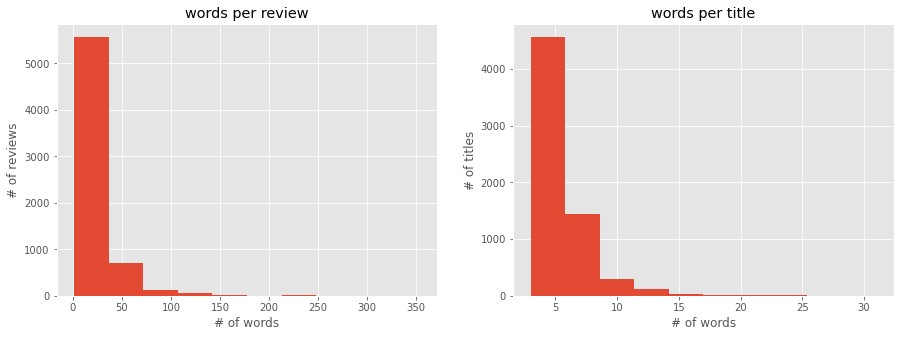

In [11]:
hist_reviews = [len(dataset[i][0].split()) for i in range(len(dataset))]
hist_titles  = [len(dataset[i][1].split()) for i in range(len(dataset))]

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('words per review')
plt.xlabel('# of words')
plt.ylabel('# of reviews')

plt.hist(hist_reviews)

plt.subplot(122)
plt.hist(hist_titles)
plt.title('words per title')
plt.xlabel('# of words')
plt.ylabel('# of titles')

plt.show()

Notamos que a maioria dos reviews tem um tamanho até **40 palavras**, assim como a maioria dos títulos possuem um tamanho de aproximadamente **6 palavras**. Baseado nisso, vamos gerar o vetor de índices e *one hot encoding* de cada palavra

In [12]:
Tx = 40 # tamanho da entrada
Ty = 6  # tamanho da saida
X, Y, Xoh, Yoh = create_onehot(dataset, word_index, Tx, Ty)
X_val, Y_val, Xoh_val, Yoh_val = create_onehot(dataset_val, word_index, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

# print("X_val.shape:", X_val.shape)
# print("Y_val.shape:", Y_val.shape)
# print("Xoh_val.shape:", Xoh_val.shape)
# print("Yoh_val.shape:", Yoh_val.shape)

[[ 12  26   3 ...   0   0   0]
 [ 12   5 245 ...   0   0   0]
 [  5  57 458 ...   0   0   0]
 ...
 [ 12  12  12 ...  12  12  12]
 [ 51   8 213 ...   0   0   0]
 [ 64  13 928 ...   0   0   0]]
X.shape: (6499, 40)
Y.shape: (6499, 8)
Xoh.shape: (6499, 40, 17858)
Yoh.shape: (6499, 8, 17858)


Alguns exemplos do formato dos dados após o pré-processamento:

In [15]:
index = 0
print("Review:", dataset[index][0])
print("Título:", dataset[index][1])
print()
print("Original após pré-processamento (indices):", X[index])
print("Target após pré-processamento (indices):", Y[index])
print()
print("Original após pré-processamento  (one-hot):", Xoh[index])
print("Target após pré-processamento  (one-hot):", Yoh[index])

Review: Bom mas o apoio de nariz é fraquinho o ferrinho de apoio do nariz.
Título: startsent É bom endsent

Original após pré-processamento (indices): [   12    26     3  1902     6  3746    13  2146     3 13313     6  1902
    11     1     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Target após pré-processamento (indices): [87 13 12  2  0  0  0  0]

Original após pré-processamento  (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Target após pré-processamento  (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Modelo

Vamos definir o nosso modelo:
 - **Encoder**: LSTM Bidirecional
 - **Atenção**
 - **Decoder**: LSTM
 
Este modelo é baseado no modelo visto na aula de Atenção.
 
 ### Atenção

In [16]:
# Definindo camadas
repeat_layer = layers.RepeatVector(Tx)
concat_layer = layers.Concatenate()
dense_layer  = layers.Dense(32)
activ_layer  = layers.Dense(32, activation="softmax")
dot_layer    = layers.Dot(axes=1)

def one_step_attention(h, s_prev):
    """
    Defina a função de atenção e retorne o vetor contexto 
    """
    s_prev     = repeat_layer(s_prev)
    concatted  = concat_layer([h, s_prev])
    dense      = dense_layer(concatted)
    activation = activ_layer(dense)
    context    = dot_layer([activation, h])
    
    return context

### Encoder-Decoder

In [17]:
n_a = 32 
n_s = 64 

post_activation_LSTM_cell = layers.LSTM(n_s, return_state=True, dropout=.25, recurrent_dropout=.25) 
output_layer = layers.Dense(len(word_index), activation="softmax")

def cria_modelo(Tx, Ty, vocab_size, n_a=32, n_s=64):
    
    X  = keras.Input(shape=(Tx, vocab_size))
    s0 = keras.Input(shape=(n_s,), name='s0')
    c0 = keras.Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    # Para mais detalhes sobre return_sequences e outros parametros das RNNs no Keras,
    # recomendamos este guia da documentação oficial https://keras.io/guides/working_with_rnns/
    h = layers.Bidirectional(layers.LSTM(n_a, return_sequences=True, dropout=.25, recurrent_dropout=.25))(X) # Encoder
    
    for t in range(Ty):
        #Decoder
        context = one_step_attention(h, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        
        outputs.append(out)
        
    model = keras.Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

Agora vamos compilar o modelo definido acima:

In [18]:
model = cria_modelo(Tx, Ty, len(word_index))
model.compile(optimizer="rmsprop", metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 17858)]  0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 40, 64)       4580096     input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 40, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]            

Grafo do modelo compilado:

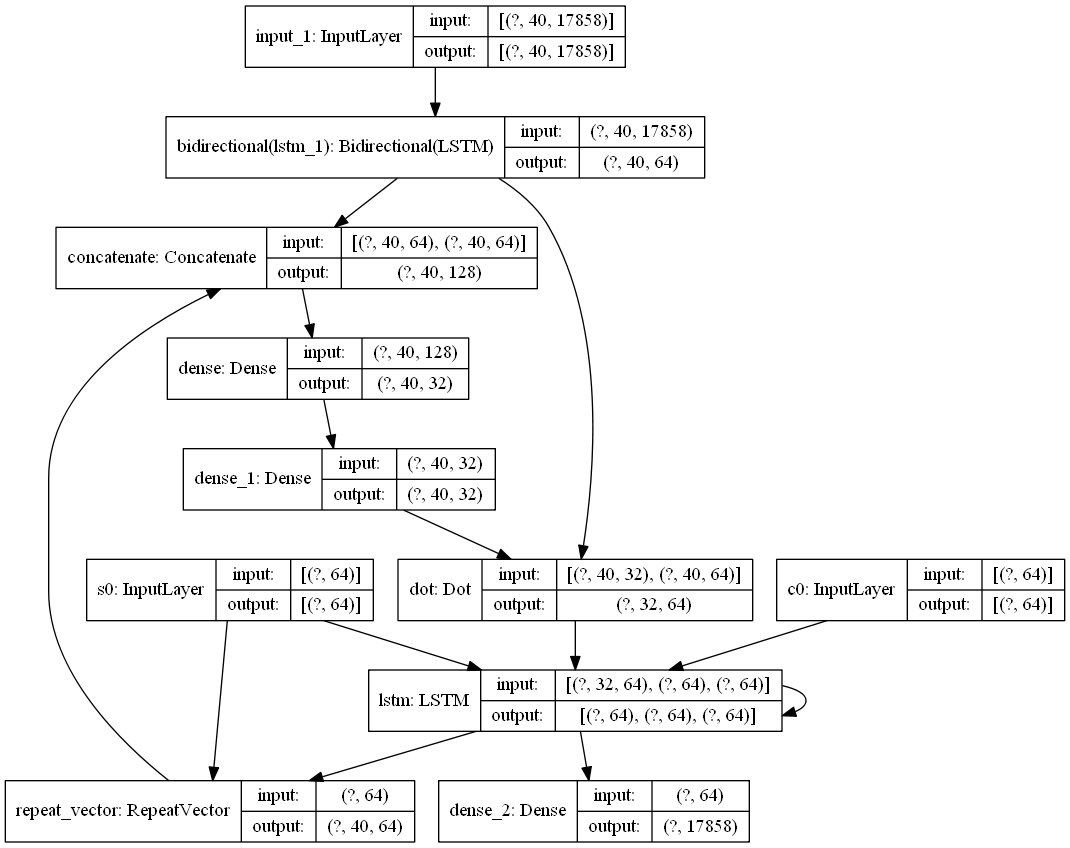

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Treinamento

Vamos treinar o nosso modelo com os dados do córpus de treinamento:

In [20]:
s0 = np.zeros((num_train_samples, n_s))
c0 = np.zeros((num_train_samples, n_s))
outputs = list(Yoh.swapaxes(0,1))

s0_val = np.zeros((num_validate_samples, n_s))
c0_val = np.zeros((num_validate_samples, n_s))
outputs_val = list(Yoh_val.swapaxes(0,1))

model.fit([Xoh, s0, c0], 
          outputs, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=([Xoh_val, s0_val, c0_val], outputs_val),
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
         )

Epoch 1/50
407/407 [==============================] - 561s 1s/step - loss: 25.9872 - dense_2_loss: 1.4029 - dense_2_1_loss: 5.9574 - dense_2_2_loss: 5.3112 - dense_2_3_loss: 4.1978 - dense_2_4_loss: 3.1937 - dense_2_5_loss: 2.4845 - dense_2_6_loss: 2.0826 - dense_2_7_loss: 1.3571 - dense_2_accuracy: 0.5284 - dense_2_1_accuracy: 0.0074 - dense_2_2_accuracy: 0.0315 - dense_2_3_accuracy: 0.2345 - dense_2_4_accuracy: 0.5339 - dense_2_5_accuracy: 0.6986 - dense_2_6_accuracy: 0.8406 - dense_2_7_accuracy: 0.8935
Epoch 2/50
407/407 [==============================] - 558s 1s/step - loss: 19.1787 - dense_2_loss: 0.0135 - dense_2_1_loss: 4.9809 - dense_2_2_loss: 4.5310 - dense_2_3_loss: 3.5819 - dense_2_4_loss: 2.5945 - dense_2_5_loss: 1.7846 - dense_2_6_loss: 1.2468 - dense_2_7_loss: 0.4455 - dense_2_accuracy: 0.9992 - dense_2_1_accuracy: 0.0862 - dense_2_2_accuracy: 0.2331 - dense_2_3_accuracy: 0.2776 - dense_2_4_accuracy: 0.5290 - dense_2_5_accuracy: 0.7018 - dense_2_6_accuracy: 0.8431 - dense

407/407 [==============================] - 572s 1s/step - loss: 17.3205 - dense_2_loss: 0.0042 - dense_2_1_loss: 4.5480 - dense_2_2_loss: 4.1251 - dense_2_3_loss: 3.2693 - dense_2_4_loss: 2.3552 - dense_2_5_loss: 1.5960 - dense_2_6_loss: 1.1051 - dense_2_7_loss: 0.3177 - dense_2_accuracy: 0.9991 - dense_2_1_accuracy: 0.1465 - dense_2_2_accuracy: 0.2510 - dense_2_3_accuracy: 0.3030 - dense_2_4_accuracy: 0.5392 - dense_2_5_accuracy: 0.7032 - dense_2_6_accuracy: 0.8417 - dense_2_7_accuracy: 0.9117
Epoch 18/50
407/407 [==============================] - 558s 1s/step - loss: 17.2425 - dense_2_loss: 0.0055 - dense_2_1_loss: 4.5501 - dense_2_2_loss: 4.1076 - dense_2_3_loss: 3.2442 - dense_2_4_loss: 2.3419 - dense_2_5_loss: 1.5799 - dense_2_6_loss: 1.0937 - dense_2_7_loss: 0.3195 - dense_2_accuracy: 0.9988 - dense_2_1_accuracy: 0.1440 - dense_2_2_accuracy: 0.2522 - dense_2_3_accuracy: 0.3047 - dense_2_4_accuracy: 0.5415 - dense_2_5_accuracy: 0.7038 - dense_2_6_accuracy: 0.8432 - dense_2_7_accur

407/407 [==============================] - 558s 1s/step - loss: 16.3883 - dense_2_loss: 0.0025 - dense_2_1_loss: 4.4479 - dense_2_2_loss: 3.9769 - dense_2_3_loss: 3.0727 - dense_2_4_loss: 2.1662 - dense_2_5_loss: 1.4553 - dense_2_6_loss: 1.0097 - dense_2_7_loss: 0.2571 - dense_2_accuracy: 0.9994 - dense_2_1_accuracy: 0.1639 - dense_2_2_accuracy: 0.2694 - dense_2_3_accuracy: 0.3547 - dense_2_4_accuracy: 0.5667 - dense_2_5_accuracy: 0.7156 - dense_2_6_accuracy: 0.8449 - dense_2_7_accuracy: 0.9275
Epoch 34/50
407/407 [==============================] - 547s 1s/step - loss: 16.2620 - dense_2_loss: 0.0057 - dense_2_1_loss: 4.4349 - dense_2_2_loss: 3.9400 - dense_2_3_loss: 3.0507 - dense_2_4_loss: 2.1586 - dense_2_5_loss: 1.4431 - dense_2_6_loss: 0.9863 - dense_2_7_loss: 0.2428 - dense_2_accuracy: 0.9988 - dense_2_1_accuracy: 0.1623 - dense_2_2_accuracy: 0.2722 - dense_2_3_accuracy: 0.3653 - dense_2_4_accuracy: 0.5679 - dense_2_5_accuracy: 0.7206 - dense_2_6_accuracy: 0.8464 - dense_2_7_accur

407/407 [==============================] - 564s 1s/step - loss: 15.4717 - dense_2_loss: 0.0015 - dense_2_1_loss: 4.3513 - dense_2_2_loss: 3.6931 - dense_2_3_loss: 2.8738 - dense_2_4_loss: 2.0301 - dense_2_5_loss: 1.3748 - dense_2_6_loss: 0.9514 - dense_2_7_loss: 0.1957 - dense_2_accuracy: 0.9998 - dense_2_1_accuracy: 0.1756 - dense_2_2_accuracy: 0.2960 - dense_2_3_accuracy: 0.4128 - dense_2_4_accuracy: 0.5981 - dense_2_5_accuracy: 0.7360 - dense_2_6_accuracy: 0.8526 - dense_2_7_accuracy: 0.9415
Epoch 49/50
407/407 [==============================] - 556s 1s/step - loss: 15.4057 - dense_2_loss: 0.0023 - dense_2_1_loss: 4.3281 - dense_2_2_loss: 3.6847 - dense_2_3_loss: 2.8589 - dense_2_4_loss: 2.0283 - dense_2_5_loss: 1.3647 - dense_2_6_loss: 0.9482 - dense_2_7_loss: 0.1904 - dense_2_accuracy: 0.9995 - dense_2_1_accuracy: 0.1790 - dense_2_2_accuracy: 0.2987 - dense_2_3_accuracy: 0.4178 - dense_2_4_accuracy: 0.6026 - dense_2_5_accuracy: 0.7387 - dense_2_6_accuracy: 0.8500 - dense_2_7_accur

## Validação

Para a validação vamos executar algumas métricas na base de teste e analisaremos a qualidade dos titulos produzidos

In [43]:
# Download do wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\davys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [82]:
# criando pair (review,title) de cada entrada do dataframe de teste
test_dataset = process_dataframe(test_df)
test_dataset = [test_dataset[i][0] for i in range(len(test_dataset))]


# with open('output_metrics_bi-lstm.txt', 'w', encoding='utf-16-le') as file:

# para cada amostra da base de testes
for example, df in zip(test_dataset, test_df['review_title']):
    # transforma amostras em one-hot
    source = string_to_int(example, Tx, word_index)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(word_index)), source)))

    source = source.reshape((1, Tx, len(word_index)))

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))

    # prediz titulo
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis=-1)

    output = [index_word[int(i)] for i in prediction]

    # processa resultados
    processed_out = ''
    for w in output:
        if w != 'startsent' and w != 'endsent' and w != '':
            processed_out += w + ' '

        if w ==  'endsent':
            break

    expected = []
    for i in df.split():
        if i != 'endsent' and i != 'startsent':
            expected.append(i)

    # salvando resultados em arquivo
    # file.write("input:    %s\n" % example)
    # file.write("output:   %s\n" % processed_out)
    # file.write("expected: %s\n\n" % ' '.join(expected))


    # file.write("BLEU:   %f\n" % translate.bleu_score.sentence_bleu([expected], processed_out.split()))
    # file.write("METEOR: %f\n" % translate.meteor_score.meteor_score([' '.join(expected)], processed_out))
    # file.write("NIST:   %f\n\n" % nist_score.sentence_nist([expected], processed_out.split(), 1))

    # file.write("==================================================================\n\n\n")

    # imprimindo resultados
    print("input:    %s" % example)
    print("output:   %s" % processed_out)
    print("expected: %s\n" % ' '.join(expected))

    # metricas
    print("BLEU:   %f" % translate.bleu_score.sentence_bleu([expected], processed_out.split()))
    print("METEOR: %f" % translate.meteor_score.meteor_score([' '.join(expected)], processed_out))
    print("NIST:   %f\n" % nist_score.sentence_nist([expected], processed_out.split(), 1))

    print("==================================================================\n\n")

input:    Produto de boa qualidade...o vidro veio um pouco marcado com sujeira q nao consiga tirar..mas ok..
output:   não gostei 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto muito bom bastante espaço vale apenas comprar não vai se arrepender
output:   produto muito 
expected: Bom demais

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto veio perfeitamente mas para quem pagou por uma entrega expressa e o produto estava no RJ chegar em SP 4 dias e ridículo.
output:   produto de do [UNK] 
expected: O produto e muito bom, mas a entrega foi péssima.

BLEU:   0.000000
METEOR: 0.053191
NIST:   0.024099



input:    A loja me vendeu como novo e me entregou um produto fabricado em 31/08/2013. Dois mil e TREZE. Validade de 6 meses. Não durou nem um décimo do que duraria um novo. Péssima loja.
output:   não com 
expected: Loja desonesta

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    infelizmente o produto não fe

input:    Antes com travesseiro comum, eu acordava com dores no pescoço e passava pra cabeça, agora acordo sem dores. Este produto foi muito bom pra mim, parabéns recomendo.
output:   muito [UNK] 
expected: Travesseiro de Molas Cervical

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não recebi o produto. Não chegou no prazo que prometeram.
output:   não recebi o 
expected: Não recebi o produto

BLEU:   0.000000
METEOR: 0.754986
NIST:   0.940586



input:    Simples e fácil de utilizar e carregar tinta. Impressão boa com nitidez e fotos ótimas.
output:   muito muito 
expected: Produto muito bom.

BLEU:   0.000000
METEOR: 0.172414
NIST:   0.396241



input:    Produto de excelente qualidade, entrega dentro do previsto.
output:   gostei 
expected: Gostei muito do produto!

BLEU:   0.000000
METEOR: 0.135135
NIST:   0.000000



input:    Chegou antes do tempo esperado.  Além de prático o berço é muito bonito.
output:   gostei 
expected: Boa qualidade. Atendeu a expectativa

input:    Não entregaram o produto Disseram que o endereço estava incorreto mas a própria lojas Americanas já entregou um pedido .
output:   não recebi 
expected: Não entregaram o produto

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.000000



input:    Muito bom. Obrigado.   Esse produto é bem conhecido por todos nós, são muito útil.
output:   gostei 
expected: Entrega

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Funciona, mas exige esforço. Fraquinho , se vc tem um mixer é dispensável
output:   excelente 
expected: Não gostei !

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Tem bom acabamento e é pratico. Serviu para o que eu precisava!
output:   produto muito do 
expected: Muito boa o produto

BLEU:   0.000000
METEOR: 0.256410
NIST:   0.470293



input:    Produto cumpre o que promete !! Até o momento sem problemas, transportadora super ágil!
output:   muito 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produ

input:    Caneta Autoclavável para Bisturi Eletrônico. Bom produto!
output:   gostei 
expected: Caneta Autoclavável para Bisturi Eletrônico

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não vale apena, pois ele resseca muito o cabelo, muito mesmo. Pelo valor do produto isso é inaceitável. há produtos no mercado que são mais baratos. Eu não compraria novamente. Um ponto positivo é que não deixa o cabelo manchado de roxo. O maior desafio de uma mulher  loira é deixar o cabelo com um aspecto saudável, e com toda certeza vai de em contro com isso. Por isso, torna-se totalmente inviável o produto.
output:   gostei muito 
expected: Não vale apena comercializar esse produto.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fiquei muito satisfeita com produto, a TV é muito bonita o som é maravilhoso e a imagem é demaissss.
output:   produto 
expected: Produto que esperava

BLEU:   0.000000
METEOR: 0.178571
NIST:   0.000000



input:    COMPREI UM, COM MÊS DE 

input:    Produto muito bom, chegou antes do previsto, recomendo a todos. Vendedor excelente.
output:   excelente 
expected: Produto muito bom, chegou antes do previsto. Loja muito boa recomendo a todos.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Só um ínfimo problema na documentação, ela não vem com o manual em português. No restante...->>EXCELENTE.
output:   produto muito 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    amei, lindo, leve, confortavel. recomendo esse produto.
output:   excelente 
expected: otimo tapete

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto muito bom, o cabelo seca rápido, pois o jato é bem forte! Recomendo.
output:   gostei produto 
expected: Excelente produto

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.500000



input:    Não é possível assistir a TV em todos os ângulos pois a imagem fica escura e com sombra, só é possível assistir imagem perfeita estando de frente para tel

input:    Excelente espaço a geladeira é muito bonita e refrigera bem até agora sem problemas quem fez a entrega foi a consul muito rapida tambem.
output:   gostei [UNK] 
expected: Muito boa!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Até o presente momento está atendendo as principais necessidades, roda bem os principais Apps, desde que usado de forma moderado. Processador poderia ser melhor e ao meu ver pecou por ter a entrada de chips híbrida, no mais até o momento sem nada a reclamar.
output:   muito muito do 
expected: Aparelho intermediário, mas com bom desempenho

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não recebi esse produto, veio outro coisa no lugar desse produto, decepcionada, quero meu dinheiro de volta.
output:   não recebi o 
expected: Não recebi esse produto

BLEU:   0.000000
METEOR: 0.480769
NIST:   0.470293



input:    Pelo valor dele nao tem opçao melhor. Tudo que é necessário para o dia a dia.
output:   [UNK] 
expecte

input:    Brinquedo como descrito no anúncio! Minha filha adorou!!!
output:   gostei 
expected: Ótimo brinquedo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ilumina o ambiente e da um designer sofisticado muito legal.
output:   gostei muito 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    ATE O MOMENTO NÃO RECEBI O PRODUTO.  E PELO EMAIL QUE RECEBI, NÃO HÁ PREVISÃO DE ENTREGA.  O PRODUTO ERA PRA PRESENTEAR NO NATAL.
output:   não recebi o 
expected: NAO RECEBI O PRODUTO

BLEU:   0.000000
METEOR: 0.480769
NIST:   0.000000



input:    Excelente aquisição. Smart excelente.  Entrega rápida, antes do prazo chegou. Recomendo
output:   gostei muito 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O jogo é bom demais e extremamente viciante. Excelente compra!
output:   muito 
expected: Gostei muito do produto!

BLEU:   0.000000
METEOR: 0.135135
NIST:   0.000605



input:    Ótimo produto, muito poten

input:    O aparelho apresenta bastante inércia nas atividades, pouco alcance na conectividade da tv, dificuldades na digitação principalmente ao ligar...  O aparelho antiga LG PRIME era excelente. Só adquiri um novo porque sua tela rachou com uma queda depois de tres anos de uso contínuo sem qualquer problemas ou insatisfações.  Desde ja agradeço o espaço e aguardo uma resposta para a minha opinião. Atte Marise Rosa
output:   de de de de 
expected: Avaliação LG K10

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    excelente produto. entrega rápida e bom preço. Valeu americanas!
output:   gostei 
expected: adoreii

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Como eu vou avaliar se eu não recebi o produto. Mandei um e-mail e ainda não tive resposta !!!!!
output:   não recebi o o 
expected: Não recebi o produto

BLEU:   0.000000
METEOR: 0.638889
NIST:   1.000000



input:    Super prática, preço excelente e entrega melhor ainda! Recomendo
output:   exce

input:    Achei lindo, too de linha,, design lindo, câmera, resposta boa, rápida, preço e prazo ,tudo certinho,,adorei o celular,,parabéns americanas,,,,nota dez,,,,
output:   muito 
expected: Maravilha

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    E o pior e que ninguem corrigiu ainda esse preco. Ta todo mundo de pileque. Perda de credibilidade...
output:   não não o 
expected: O cara so pode estar chapado de pinga

BLEU:   0.000000
METEOR: 0.066667
NIST:   0.000000



input:    eu cancelei a compra do produto e a americanas não devolveu o valor pago.
output:   não recebi o produto 
expected: americanas não faz o estorno da minha compra

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.197857



input:    Gostei muito do produto é bem resistente grande fácil de limpar e é  linda
output:   muito 
expected: Gostei muito

BLEU:   0.000000
METEOR: 0.263158
NIST:   0.131905



input:    Qualidade sensacional!  Medo da traseira de vidro, mas em quase dois meses nada aconteceu 

input:    Desde o dia que recebi até hoje não posso usar a cadeira,pois vieram faltando peças para a montagem. Entrei em contato com um telefone que veio, no mesmo dia que recebi a cadeira e até agora nada das peças. Ou seja um trambolho na minha sala sem eu poder usar.
output:   não não o o 
expected: Não recomendo

BLEU:   0.000000
METEOR: 0.227273
NIST:   0.000000



input:    Produto muito bom, super recomendo!!! Chegou rápido.
output:   gostei 
expected: Maravilhoso!!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não compre se for dá Up2games ela rouba seu dinheiro ! É vergonhoso como a americanas tem parceria com esse lixo de loja !
output:   up2games não entrega os produtos pelo 
expected: Up2games não entrega os produtos pelo contrário rouba seu dinheiro !

BLEU:   0.330223
METEOR: 0.570106
NIST:   0.612478



input:    Celular ótimo, bom desempenho, entrega rápida antes do prazo
output:   gostei 
expected: Um ótimo produto

BLEU:   0.000000
METEOR: 0.00000

input:    Produto muito bonito atendeu as expectativas, e preço justo também.
output:   muito 
expected: excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não é tão vermelho mas é um bom produto recomendo muito bom o preço
output:   gostei 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    chegou rapido em minha casa, mais pode melhorar a forma de envio pois veio em uma caixa de papelao e, devido ao movimento do caminhao pode ocorrer dano.
output:   produto [UNK] 
expected: gostei muito do produto

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.131905



input:    Como posso avaliar o produto se ainda não o recebi? Já a mais de um mês estou esperando era para vir no Natal e depois houve problemas na entrega o prazo ficou para dia 26/12 entro no site e diz q está em transporte e prazo de entrega dia 27/12! Estou com uma criança de 06 anos esperando o presente de natal. Acho um absurdo até agora nem mais nenhum retorno foi dado e a

input:    Muito bonito, bem prático e funcional; material excelente e fácil de montar. Estou realmente satisfeito com o produto.
output:   excelente 
expected: Excelente

BLEU:   0.000000
METEOR: 0.500000
NIST:   0.000000



input:    já tenho ela ha uns 2 anos e pouco muito boa recomendo
output:   [UNK] 
expected: amei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Atende as minhas necessidades muito prático. Faz tudo que se propõe com perfeição indico a compra do mesmo.
output:   produto muito 
expected: Ótimo produto

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.500000



input:    Adorei os óculos. Ótimo custo benefício. Entrega rápida.
output:   gostei 
expected: Satisfeita

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Veio faltando o controle  remoto, enviei mensagem reclamando, até agora não obtive resposta.
output:   não o o produto 
expected: Gostei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Só não entendo porque a amer

input:    Tudo ótimo, só faltou o principal q seria a memória do anúncio. 2gb a mais. Propaganda enganosa.
output:   produto muito do 
expected: Descrição 4gb veio com 2gb

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    adorei o celular, estou arrasando com ele mas o melhor de tudo foi ter mamado o entregador <3
output:   gostei muito do 
expected: AMEI

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Prezado srs responsáveis pelo site de compras da AMERICANAS . Revisem vossa maneira de LOGISTICA , pois a mesma me deixou decepcionado até o momento estourando o prazo de entrega e muito ... sem atualização de rastreio pelo site etc. Só cabe uma pergunta : ONDE ESTÁ MEU PRODUTO PAGO Á VISTA ? QUANDO E DE FATO SERÁ ENTREGUE MEU PRODUTO ? FOLMER
output:   produto o o o o 
expected: O produto deveria ter sido entregue dia 28-12-17 e até o momento dia 07-01-18 nada ...

BLEU:   0.000000
METEOR: 0.100671
NIST:   0.005331



input:    Muito melhor que a velha pa

input:    Muito ruim essa lavadora. Por ser uma Brastemp poderia ser bem melhor. O sistema de lavagem é péssimo. A roupa não é batida suficiente para lavar de fato. Desperdiça sabão e não lava. Esse batedor central dela é muito ruim, come espaço na lavadora e a roupa fica preso a ele num vai e volta inútil. Nota zero pra Brastemp.
output:   não com 
expected: Não gostei do produto

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.000000



input:    O produto é ótimo como anunciado. O único problema foi a demora na entrega quase um mês.
output:   gostei 
expected: Otimo produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Tv muito boa pode compra sem medo o preco muito bom
output:   gostei 
expected: Luciano

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Mochila feita de um tipo de Napa, parece q irá rasgar fácil
output:   gostei muito do 
expected: Material ruim

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Escolhi o produto por simp

input:    Gostei do aparelho muito lindo, camera boa,memoria boa, só a bateria que poderia ser melhor. Estou usando a poucas semanas então não tenho muito o que falar.Por enquanto está tudo ok!
output:   produto de 
expected: Lindo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Cafeteira exelente pelo preço,passa o café rápido amei indico 100%
output:   ótimo 
expected: Maravilhosa

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei do Ferro de passar  Ótimo produto eficiente
output:   gostei muito 
expected: Produto de qualidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    MEU FILHO AMOU, ATÉ  O MOMENTO PRODUTO PERFEITO, ÓTIMO TAMANHO, BOA QUALIDADE.
output:   excelente 
expected: MEU FILHO AMOU

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Recomendo para seu filho, ele pode criar usar a imaginação.
output:   produto 
expected: Gostei, ótimo produto.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



inpu

input:    Apesar do anúncio descrever "carga rápida", meu aparelho demora 7 (sete) horas para carregar completamente a bateria. Menos de um mês de uso e já está na assistência. Uma decepção.
output:   não de 
expected: Carga Rápida?

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Um excelente jogo pra quem é fã da saga. Gráficos perfeitos, personagens novos e uma história bacana.
output:   muito muito 
expected: Perfeito!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Melhora a pegada do console e encaixa perfeitamente.
output:   gostei produto 
expected: Gostei do produto

BLEU:   0.000000
METEOR: 0.344828
NIST:   0.396241



input:    A americanas sempre entrega no prazo, show. Menos os parceiros dela.
output:   não produto 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei muito do produto, era tudo o que eu precisava
output:   excelente 
expected: excelente

BLEU:   0.000000
METEOR: 0.500000
NIST:   0.0000

input:    Produto de excelente qualidade e entrega efetuada antes do prazo estabelecido. Recomendo a loja.
output:   ótimo 
expected: Produto excelente!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo produto como prometido. A entrega também muito antes do prazo.
output:   gostei produto 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    superou a expectativa, muito bom recomendo. vou comprar mais um logo
output:   muito 
expected: cpu

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto não funciona com chip, já pedi devolução do meu dinheiro e até agora não houve contato por parte do fornecedor.
output:   não recebi recebi 
expected: Quero fazer a devolução

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Recomendo lindo !!!excelente...,corresponde minha necessidade,rapido sem palavras ,compraria de novo 10,.
output:   produto 
expected: Top lindo!!!!!

BLEU:   0.000000
METEOR: 0.000000
NIST: 

input:    Meu filho gostou e bla bla bla ate o texto ficar cumprido suficiente para eu poder mandar a mensagem, será que agora já está bom?
output:   produto 
expected: gostei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Indico o produto para todos e o atendimento das Americanas de excelente garantia.
output:   muito 
expected: Gostamos muito do produto, excelente qualidade!

BLEU:   0.000000
METEOR: 0.090909
NIST:   0.000003



input:    Superou minhas expectativas,linda d+ e muito rápida !!!!
output:   ótimo 
expected: Gostei muito!!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente o produto, entrega rápida tudo perfeito!!!!!
output:   gostei 
expected: Avaliação do produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    ATÉ AGORA NÃO RECEBI O PRODUTO E NEM FUI INFORMADO OQ ACONTECEU COM A ENTREGA.O SITE DE RASTREIO NUNCA É ATUALIZADO. NA VERDADE SÓ CONSTA UMA ATUALIZAÇÃO DO DIA 08/12/17, SENDO Q O PRODUTO ERA PARA TER 

input:    É ótimo, eu já tinha o MotoG3, adorei que comprei o MotoG5, é um celular muito bom.
output:   gostei 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito bom, eu ameeei Chegou em perfeito estado, impecável.  Recomendo
output:   excelente 
expected: Maravilhoso

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    até então, perfeito. Tudo que pretendia com ele, fiz........
output:   gostei muito do 
expected: excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fiz a compra dia 04/12/17 e Ainda nem recebi meu relógio. Que inrresponsabilidade e falta de consideração com o cliente
output:   não recebi o produto 
expected: Atado absurdo na entrega

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Nao recebi o produto ! Nao recebo retorno! Decaso total! Super insatisfação
output:   não recebi o 
expected: Nao recebi o produto

BLEU:   0.000000
METEOR: 0.480769
NIST:   0.940586



input:    Chegou p

input:    Produto não recebido até o momento Pedido postado em 12.12.17 previsão de entrega 27.12 e até hoje o status da entrega não. Muda.
output:   não não o o 
expected: Produto não recebido até o momento. Há 1 mês a quadrado a entrega

BLEU:   0.000000
METEOR: 0.082645
NIST:   0.005290



input:    bom aparelho MAIS ainda está caro mais se abaixar vou comprar
output:   produto 
expected: se baixar o preço vou comprar 2

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo produto. Vale a pena adquirir, eu recomendo. Atendeu sim todas minhas expectativas. Preço acessível!
output:   excelente 
expected: Correspondente ao esperado!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    péssima qualidade! No 2 dia de uso a escova não funcionou mais. Começou a sair fumaça e derreteu a borracha.
output:   não não 
expected: avaliação

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei para meu neto de cinco anos, achei ótimo.   Comprei out

input:    Para substituição de outros óleos na culinária. Exceto para temperar, nesse caso o melhor é  o azeite de oliva.
output:   produto de do de 
expected: Óleo de Coco

BLEU:   0.000000
METEOR: 0.161290
NIST:   0.396241



input:    Péssimo atendimento.... Pessoas despreparadas.  Ainda exige texto longo. Péssimo, péssimo, péssimo atendimento por parte das loja americana e seus funcionários. Pronto... Texto grande agora.
output:   [UNK] 
expected: Site péssimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Jogo bom, ótima qualidade entrega rápida, mas enredo do game razoável, varia de gosto.
output:   gostei muito do 
expected: Bacana

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Aparelho lindo e ainda chegou antes do programado.
output:   produto 
expected: satisfeita. Adoreiiiiii

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO

input:    Não posso avaliar, pois ainda não recebi o produto.
output:   não recebi o 
expected: Ainda não recebi o produto

BLEU:   0.000000
METEOR: 0.613426
NIST:   0.772763



input:    É leve, tem ótima sucção, muito potente... Recomendo
output:   excelente 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito prático, fácil manuseio, monta e desmonta rapidamente. Minha filhinha amou... Vale a pena!
output:   produto muito 
expected: Maravilhoso

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gb gostei e Eu recomendo a todos produto muito bom
output:   gostei produto 
expected: Gostei muito

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    muita bom produto chegou no prazo, facil de montar a unica coisa q poderia ser melhor e o travamento da parte frontal da gaveta mas com um reforço de mais uma cantoneira fica 10.
output:   gostei muito do [UNK] 
expected: gostei da comoda.

BLEU:   0.000000
METEOR: 0.161290
NIST:   

input:    Produto em plástico de espessura frágil, porém de funcionalidade aceitável.Serve sómente para uso doméstico leve. Serviço pesado nem pensar. Cumpre o que promete na propaganda.
output:   muito muito 
expected: Produto em plástico pouco resistente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito bom o produto, recomendo para quem não queira gastar muito
output:   gostei 
expected: Custo x Benefício

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto veio com algumas avarias, uma lasca frontal e um amassado. Faltou 1 fixador do fundo da estande.
output:   não produto 
expected: esperava mais do produto

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.131905



input:    PRODUTO NÃO CHEGOU ATÉ A DATA DE HOJE. FIZ A COMPRA DIA 01/12/2017... DESCASO COM CONSUMIDOR!!!!!!!!!!!!!!!!!
output:   não recebi o produto 
expected: HORRIVEL!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo custo benefício. Só tem um probleminha

input:    Eficiência na entrega e cumpriu o combinado na qualidade do produto.
output:   gostei produto 
expected: Eficiência na entrega e cumpriu o combinado

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Amei o celular, ja estou com ele ha 20 dias e estou amando, principalmente a câmera que tem flash frontal maravilhosa!!  Nunca consegui tirar boas fotos a noite, agora tiro e ficam lindas!
output:   não de 
expected: LINDO E OTIMA CAMERA

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente brinquedo !Toda a familia se diverte pois não da pra jogar sozinho!Meu filho q so jogava videogame agora nap quer outra coisa!A participação da familia é estimulada nesse jogo!
output:   [UNK] 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Bom produto e bonito. Mas as vezes trava. E fica difícil de voltar as funções. Tem dificuldade de conexão com a internet. A bateria carrega rápido e dura bem.
output:   produto muito 


input:    paguei o boleto e a loja nao entregou agora preciso brigar passar raiva para receber de volta meu dinheiro ,sempre comprei na americana agora estar pessimo o atendimento
output:   não produto 
expected: produto

BLEU:   0.000000
METEOR: 0.454545
NIST:   0.000000



input:    Muito bom o produto. Gostei da Tela, da fluidez e principalmente de poder dividir a tela em dois aplicativos.
output:   excelente 
expected: Samsung Galaxy Tab S3

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Boa noite, venho por meio desta solicitar a troca do meu produto, que a menos de um mês apresenta problemas. Super aquecimento, que é muito perigoso, tenho receio que ele exploda na minha mão ou orelha. Além da lentidão e travamentos. Ele não ficou exposto ao sol em nenhum momento, e nem sofreu nenhum tipo de queda, por isso o meu desapontamento. Saí de um IPHONE para um Android e que então me deixou decepcionada. Um celular que custou bem caro e apresentar defeito em menos de um m

input:    Bom funciona direito gostei faltou detalhes como carregar posição da chave se ligado ou dealugado carrega no mais tudo blz obrigado feliz 2018
output:   produto muito 
expected: Carregador silar

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fiz a compra de uma faca:Faca Do Chef Lâmina Longa 8 Aço Inox Linha Zwilling Pro - Zwilling,pelo site das lojas americanas,vendida e entregue pela tool box,  porem recebi uma faca:Faca Chef 8” Zwilling Gourmet Zwilling J.A. Henckels,produto inferior e diferente ao anunciado tanto pelo nome como pelas fotos no anuncio.
output:   não não o o 
expected: Produto com especificação incorreta

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei bastante do produto. Atendeu as minhas necessidades.
output:   gostei muito 
expected: Gostei bastante

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    bonitinho...deve ser bom :) ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh o texto de an

input:    Atendeu perfeitamente nosso desejo, seja pela qualidade, seja pelo tamanho ou pelo preço.
output:   muito 
expected: Otimo.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Parece original veio com os lacres e tudo certo.entregou até rápido por ser final de ano.
output:   não de do 
expected: Parece original

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não recebi o produto e ninguém me da um posicionamento. Já enviei dois emails e quando decidem responder, não explicam direito. 1 e última vez que o eu compro com vocês. E eu espero receber o produto.
output:   não recebi recebi 
expected: Não recebi o produto

BLEU:   0.000000
METEOR: 0.256410
NIST:   0.470293



input:    A xícara vem acondicionada  em uma caixinha na mesma estampa da caneca, cores vivas muito boa só a tampa que deveria ser mais ajustada a caneca pq como ela é bem maior fica parecendo um pires em cima por exemplo.
output:   não de de de 
expected: Vale a pena

BLEU:   0.000

input:    Aparelho atendeu minhas expectativas e necessidades, recomendo o mesmo.
output:   gostei 
expected: excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto com peças grandes porém achei fraco a qualidade do plástico. Mas a criança pode brincar em segurança.
output:   não de do 
expected: Um bom produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    produto bom, entrega antes do previsto. ............................................
output:   gostei 
expected: produto bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O aparelho é muito confortável na mão e o seu desempenho é algo que chama atenção, na parte das fotografias é um outro ponto positivo.
output:   muito 
expected: Muito bom o produto

BLEU:   0.000000
METEOR: 0.135135
NIST:   0.000000



input:    É um celular grande, rápido e com muita memória. Na minha opinião, possui muitas vantagens quando comparado com outros na mesma faixa de preço.
output:   mui

input:    gostei muito das banquetas combinou muito com a minha decoração. a única coisa que não gostei é a marcação que veio feita para o encaixe do encosto, tivemos muito trabalho pra montar
output:   produto de do de de 
expected: gostei muito do produto

BLEU:   0.000000
METEOR: 0.243902
NIST:   0.800000



input:    Eu amei, ela é linda, ja usei 2 vezes , a centrífuga funciona mt bem, as roupas saem quase secas. Só o tempo de lavagem que eu acho longo, 2 horas  pra lavar... Eu não sei se é mt mas o desempenho da máquina é de bom a ótimo.
output:   não de 
expected: Adorei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Superou a expectativa pelo preço  Fotos em ótima qualidade
output:   muito 
expected: Câmera action

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Valeu a pena esperar as promoções da Americanas.com para adquirir um produto que já estava pensando em comprar.
output:   produto 
expected: Otimo custo benefício e entrega

BLEU:   0.00

input:    Chegou tudo em perfeito estado, jogo sensacional !!!
output:   excelente 
expected: Perfeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente barbeador. Atendeu as expectativas. Fácil manuseio.
output:   gostei 
expected: Barbeador

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Aparelho bom para o custo beneficio, recomendo a compra desse produto
output:   gostei muito 
expected: Bom e bonito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Falta descrição de quantas polegada é  a tv anunciada.
output:   não 
expected: Polegadas

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Esse tampão veio com medidas de encaixe errado,vai ser preciso mandar ajustar a medida correta.
output:   não de e de 
expected: Medidas fora de padrão

BLEU:   0.000000
METEOR: 0.125000
NIST:   0.500000



input:    Meu esposo ficou muito feliz com o kit, carretilha excelente, porem a vara que veio não e apropriada para carreti

input:    Recebi peças quebradas e até agora nenhuma solução... aguardo no email bjmovio@gmail.com ou no telefone 011969967776
output:   não recebi 
expected: Recebi peças quebradas e até agora não recebi nenhuma posição sobre o meu caso

BLEU:   0.000000
METEOR: 0.146484
NIST:   0.000000



input:    Produto muito bom recebi dentro do prazo  Recomendo
output:   gostei 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Meu sobrinho amou esse jogo, era tudo que ele queria, com certeza acertei na compra, chegou antes do prazo eu recomendo.
output:   produto de do 
expected: Maravilhoso

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Amei o aparelho de jantar e as Americanas entregaram antes da data prevista, super recomendo!
output:   excelente 
expected: Amei o produto!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Demora no envio, veio com lascado na lateral, produto grosseiro nada a ver com o original da Motorola. Não go

input:    Não compre, a imagem das câmeras são péssimas, não da para ver o rosto da pessoa filmada ou seja só da pra ver que tem alguem, mas não da pra indentificar nada.
output:   [UNK] 
expected: Péssima imagem

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Design lindo! Ferve o café rapidamente e mantém a temperatura por muito tempo!
output:   produto 
expected: Linda e potente!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo produto, capacidade excelente, velocidade rápida (com o uso do USB 3.0), produto entregue antes do prazo, embalagem intacta. Recomendo!
output:   gostei muito 
expected: Otimo em tudo.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto excelente, ótimo acabamento e conteúdo.  O que deixou a desejar foi a entrega, o livro chegou com algumas danificações o que incomodou bastante a satisfação nesse quesito.
output:   produto muito do 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    atendeu as expectativas das presenteadas, pois é um ótimo produto
output:   gostei 
expected: muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    É um ótimo produto tem se a ideia de cinema, penso que o consumidor não se arrependera.
output:   não o o produto 
expected: gostei desse produto

BLEU:   0.000000
METEOR: 0.161290
NIST:   0.396241



input:    Uso para trabalho, produto muito bom, atende minhas necessidades.
output:   gostei 
expected: Otima

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto deveria ter sido entregue até o dia 20 de dezembro de 2017, não foi, pedi o reembolso e o mesmo apenas será realizado segundo a americanas.com se o produto retornar ao fornecedor. Então se ele nao chegar à minha residência, no caso de extravio, vou paga-lo de mesma forma?? Não realizo mais nenhuma compra na americanas.com após este ocorrido.
output:   não recebi o produto 
expected: Produto extraviado

BLEU:   0.000000
METEOR: 0.22

input:    Muito bom esse produto recomendo, está de parabéns
output:   gostei 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Show de bola esse not. Parabens a Samsung. Evoluiu na produção dos nots gamer.
output:   gostei muito do 
expected: PERFEITO

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Olha o preço, gente, OLHA O PREÇO! Vc piraram? Tão loucos? Q q isso Amricans.
output:   muito 
expected: Mas que isso Americanas

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto atende todos os meus requisitos .. muito boa .. vale muito a pena .. entrega dentro do prazo .. tudo certinho
output:   muito 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Prepara bem as pipocas e não necessita óleo, comprei para minha mãe e ela gostou muito, bem prático (achei que fosse maior, mas não cheguei a ver as dimensões do produto, não chega a ser um ponto negativo, pelo contrário, dá pra fazer p

input:    Trabalhar com terceirização nem sempre é um bom negócio ... vou lembrar disso quando eu pensar em voltar a comprar nas americanas . Nunca recebi o produto
output:   não recebi o 
expected: Não recebi o produto

BLEU:   0.000000
METEOR: 0.754986
NIST:   0.940586



input:    Um produto de ótima qualidade,fácil de usar. Vale muito a pena.
output:   gostei 
expected: Produto maravilhoso

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Nada fora do normal.   Xxxx Xxxxxxxxxxxxxxxxxxxxxxxxxxx xxxxxxxx
output:   gostei produto do 
expected: Bom. Xxxxxxxx

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O aparelho poderia ser um pouco maior para facilitar a digitação e o relógio na tela principal não funciona direito, sempre está com divergência de horas.
output:   não de do 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Entregaram direitinho, gostei muito do produto, vou até comprar outro.
output:   produto 
expected: 

input:    Fiz a compra dia 05/12/2017 e não recebi o produto até hoje, já mandei vários email e nenhum retorno tive,  era presente de natal pra minha filha :(
output:   não recebi o 
expected: Falta de compromisso com clientes

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    qualidade ok, tamanho bom. mangueira que conecta ao gas veio no tamanho errado.
output:   não de 
expected: ok

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    excelente produto recomendo superou minha expectativa.
output:   excelente 
expected: superou minha expectativa

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Presente criativo e barato ,creio que pelo valor e uma boa opção para complementar
output:   produto 
expected: Bom custo beneficio

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto chegou antes da data que foi prevista. O material parece bom, mais reforçado. Capacidade ótima também. Porém o barulho realmente é meio espantoso, mas

input:    adorei! as bebidas sao deliciosas, e a maquina é super rapida. bebida sai bem cremosa
output:   gostei muito do 
expected: muito satisfeita

BLEU:   0.000000
METEOR: 0.238095
NIST:   0.333333



input:    Muito bom para o uso do dia a dia ,em tamanho e qualidade, realmente vale a compra, tudo, na perfeita ordem.
output:   muito 
expected: Perfeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Notebbok muito bom! Rápido pequeno e leve para quem quer um notebook com um bom desempenho e que oculpa pouco espaço ele é perfeito. A autonomia da bateria é muito boa. Ele liga e desliga muito rápido.
output:   muito muito 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    Pior compra já feita, não costura nada, comprei 2 maquinas , e nenhuma costura. o defeito é o mesmo,
output:   não não o 
expected: não serve pra nada, por favor não compre, péssimo produto!

BLEU:   0.000000
METEOR: 0.107527
NIST:   0.003432



input:    Produto s

input:    Produto sem fixação.  Já foi feita a devolução do produto. Aguardando estorno.  Att,
output:   não recebi 
expected: Sem fixação

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    esse aparelho tem flash frontal? e leitor digital?
output:   não o o produto 
expected: pergunta

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Sensor de presença de baixo alcance, funciona apenas se estiver bem perto do aparelho e fazer muitos movimentos. Não atendeu minha necessidade. Não recomendo!
output:   produto [UNK] 
expected: Não gostei do produto

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.131905



input:    Excelente, indico a comprar. Fácil instalação, manual de ótima leitura.
output:   gostei 
expected: Produto excelete

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    o produto é de muita qualidade, e funciona muito bem
output:   gostei 
expected: excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    só achei pequen

input:    Não posso avaliar uma mercadoria se ainda não chegou
output:   não recebi o 
expected: Não posso avaliar uma mercadoria se ainda não chegou

BLEU:   0.000000
METEOR: 0.059524
NIST:   0.006515



input:    Produto bem acabado e com funcionamento perfeito. Cumpre as especificações.
output:   muito 
expected: Ótimo produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Prazo de entrega bom. Mercadoria recebida perfeitamente.
output:   não 
expected: Gostei muito.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Guarda roupa pequeno conforme especificações atende tb como armario multiuso.
output:   gostei 
expected: Conforme as especificações

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Superou expectativas, entrega super rápida. Recomendo!
output:   excelente 
expected: Excelente

BLEU:   0.000000
METEOR: 0.500000
NIST:   0.000000



input:    Bom dia!!  já estou estressada com vocês. minha entrega estava prevista pro dia 29 

input:    Ótimo produto atendeu minhas expectativas.recomendo .para quem procura diversão com qualidade.
output:   ótimo 
expected: Ótimo produto

BLEU:   0.000000
METEOR: 0.263158
NIST:   0.000000



input:    Produto bom, mas com matérias inferiores, não ira durar muito tempo!!!!
output:   não o 
expected: Produto bom!!!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo produto para quase todas a sua idades, inclusive adultos!
output:   produto 
expected: Ben 10 foguete bolha de sabão

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Boa Noite. Comprei um celular na Americanas e ele foi entregue em 11/12/2017, desde a compra o celular sempre desligava e travava na tela Samsung e não reiniciava e isso aconteceu 3 vezes desde a compra e ele sempre esquentava muito e eu nessas três vezes com muita dificuldade consegui fazer ele funcionar a partir daí na quarta vez ele parou de carregar e quando carregava era com muita dificuldade e do nada ontem qua

input:    PRODUTO PERFEITO, ENTREGARAM MUITO ANTES DO QUE FOI INFORMADO. SUPER RECOMENDO.
output:   gostei 
expected: LINDO PRODUTO

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto ok. Frete muito caro! Nas proximas compras vou repensar se compro neste site..
output:   gostei produto 
expected: Manopla Sandero

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    agilidade durante a entrega, produto é lindo e silencioso, mas acredito q veio com um pequeno defeito, da velocidade 1 ao 4 não funciona...
output:   gostei muito 
expected: bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei do produto! Valeu a pena a compra. Atendeu ao objetivo para o qual foi adquirido!
output:   muito 
expected: Hd muito bom

BLEU:   0.000000
METEOR: 0.178571
NIST:   0.009773



input:    Tem que comprar as chaves para terminar de montar, no restante nota 10.
output:   gostei muito do 
expected: Muito boa

BLEU:   0.000000
METEOR: 0.238095
NIST:   

input:    MUITO LEVE E PRATICO FÁCIL DE LEVA, ÓTIMO PRA TRABALHOS DE FACULDADE.
output:   excelente 
expected: ÓTIMO

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto chegou rápido. Gostei do produto, instalação fácil e rápida.
output:   gostei muito 
expected: Recomendo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ela é uma gracinha mas não tem divisão e eu achei que seria de outro material aquele lavavel nao de tecido esperava um poquinho mais da bolsa ....
output:   não 
expected: Ela é linda porem...

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    MUITO LEVE E PRATICO FÁCIL DE LEVA, ÓTIMO PRA TRABALHOS DE FACULDADE.
output:   excelente 
expected: TOP

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto excelente. Pesquisei bastante outras marcas mas resolvi optar pela eletrolux e não me arrependi. Silenciosa o espaço muito bom .
output:   produto produto do 
expected: Geladeira Eletrolux

BLEU:   0.0000

input:    O produto nao fez o cacho e ainda agarrou o cabelo! Tive que cortar!
output:   gostei 
expected: Nao recomendo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei o produto no início de Dezembro para entregar minha filha de Natal.  Naquela fantasia da criança de papai Noel entrega estava prevista para o dia 22/12/17  estamos no dia 08/01/18 E o produto não chegou.  Cancelei meu pedido no dia 21/12 E segundo atendente o produto chegaria a minha residência para eu não receber deixar ele voltar para o remetente para eu poder receber meu estorno. Até hoje não chegou esse produto.  a tarde e fui comprar outro na loja para manter a fantasia da minha filha com relação ao papai Noel  Agora estou aguardando como sera feita a devolução do meu dinheiro no cartão de crédito.
output:   não não não não não 
expected: Não recebi o produto

BLEU:   0.000000
METEOR: 0.121951
NIST:   0.000000



input:    Só de amarrar soltou pedaços do courino e quando retornei não tinha 

input:    Eu não fui buscar o produto no endereço, porém já fui informado que chegou, minha avaliação é sobre a rapidez da entrega e não do produto visto e testado. Obrigado
output:   não o o o 
expected: ainda não testei

BLEU:   0.000000
METEOR: 0.161290
NIST:   0.396241



input:    atende ao que esperava dele, instrumento com boa acústica, bonito e com um otmo preço tbm.
output:   muito muito 
expected: otmo instrumento

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Equipamento ótimo, foi o que esperava, estou muito satisfeito, parabens Lojas Americanas. Entrega super rápida.
output:   ótimo 
expected: Ótima compra

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    ótimo produto muito pratico o bebê adora ficar deitado e facilita muita a movimentação do mesmo.
output:   produto 
expected: ótimo produto

BLEU:   0.000000
METEOR: 0.263158
NIST:   0.131905



input:    Sou grato ao fornecedor que me atendeu tempestivamente com um produto muito bom.
outp

input:    Chegou antes da data especificada e o produto é muito bom consigo carregar o meu celular até 4 vezes.
output:   gostei muito do 
expected: Ótimo Produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei faz mais de um mês e o produto ainda não foi entregue, além de ter passado da data de entrega a loja WITLER DRUMS encaminhou o pedido para minha cidade somente após ter aberto uma reclamação junto a americanas.com isso ja depois de 20 dias aguardando a entrega, sendo que aqui também não deram a minima atenção. CONCLUSÃO: meu único intuito de comprar pela internet era receber em casa o produto, e me mandaram ir no correios pessoalmente retirar que fica longe da minha casa após um mês da compra sem nenhum motivo. Eu não tenho condições nem tempo de ir buscar, tenho apenas 2 dias para tirar por conta dos feriados e perdi totalmente a vontade e a empolgação que estava de receber o instrumento, não recomendo essa loja a ninguém, responsabilidade, comunicação 

input:    Não sei se o conteúdo é tão bom, mas meu sobrinho ficou empolgado para ler
output:   [UNK] 
expected: Dei de presente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Sony é garantia de produto de qualidade superior, muito bom sempre !!!
output:   gostei 
expected: Impecável

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Infelizmente, até hoje, dia 08 de janeiro de 2018, não recebi o meu produto que era para ter sido entregue até o dia 29 de dezembro de 2017. Estou muito chateada, pq nem os correios, nem as lojas Americanas ainda me deram uma resposta concreta ou pelo menos satisfatória se vou receber o meu produto ou se pelo menos vou ser ressarcida.  Sempre faço compras pela internet,em outros sites e isso nunca aconteceu: deu não receber o produto. Espero realmente que eu não sai no prejuízo.
output:   não recebi o produto 
expected: Não posso falar de um produto que , infelizmente, eu não recebi.

BLEU:   0.000000
METEOR: 0.089286
NIST:  

input:    Almofada super macia, e a entrega foi mega rápida. Fiz a compra dia 02.01.18, recebi o produto dia 05.01.18.  Super recomendo.
output:   não gostei 
expected: É maravilhoso!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Boa tarde, o produto chegou em ordem e não demorou pra chegar fiquei  muito satisfeito.
output:   produto 
expected: bom de mais

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Aparelho muito funcional até dar defeito 5 dias após a entrega. 3 usos apenas. Desapontada
output:   muito 
expected: Defeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Legal nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
output:   gostei 
expected: legal

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Adorei o produto, recomendo! Só não compr

input:    O celular não dura a bateria, passa horas carregando e quando você vai usar ele esta descarregado.
output:   não 
expected: BATERIA HORRIVEL

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto de fácil instalação e super prático, além de ficar escondido e proporcionar um ótimo visual.
output:   muito 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostamos muito da cafeteira é muito prática e os cafés são muito bons, mas quando comprei estava no site que a cor era preta, porém a cor que predomina é o cinza escuro, somente com uma faixa preta no meio... Só acho que deveriam avisar que são duas cores...
output:   produto muito do de de 
expected: Produto excelente!!

BLEU:   0.000000
METEOR: 0.217391
NIST:   0.000000



input:    Uma boa tv. Bastante recursos, com wifi integrado e fácil de usar. Boa imagem, apesar de não ser full HD, que estranhamente não se encontra nesta medida de tv (32pol). Bem funcional Entrega dentro 

input:    O relógio é grande, bonito e com funções legais, mas comprei para medir batimentos. Não consegui fazer medir batimentos depois do primeiro uso. Já tive outros frequencímetros e isso só acontecia quando acabava a bateria. Usei 3 vezes e só consegui medir na primeira
output:   não de 
expected: Difícil de usar e dificuldade pra monitorar batimentos

BLEU:   0.000000
METEOR: 0.067568
NIST:   0.000454



input:    Produto de ótima qualidade e muito resistente! Recomendo a loja Lcg eletro também que fez a entrega antes do previsto. Mayara
output:   excelente 
expected: ótima qualidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente produto, preço competitivo, entrega rápida, recomendo!!!!
output:   gostei 
expected: Excelente produto!!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei o produto, mas nunca o recebi pois o vendedor cancelou a compra/entrega sem explicações
output:   não não o o o 
expected: Não recebi

BLEU:   0.00

input:    Meus filhos amaram as cuecas Boxer Sem Costura Ocean Weare super recomendo! Tecido super macio, cores bonitas!
output:   gostei 
expected: Super macias as cuecas

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Material de péssima qualidade  Não indicaria a ninguém
output:   não 
expected: É ruim

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Campanha ridícula, cheguei ao fim em algumas horas de jogo sem esforço.
output:   produto 
expected: Call Of Duty WWII

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    muito bom. recomendo. é rápido o processador. bateria dura bastante. bonito, estou satisfeito
output:   excelente 
expected: gostei muito do produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Brinquedo com falas engraçadas e uma opção para ensinar as meninas largarem a fralda.
output:   produto 
expected: Little Monny

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Recomendo!!! Bem esp

input:    Visual antiguinho mas de bom desempenho, possui iluminação para fotos normais e também para selfies, além do leitor biométrico. Tela de boa iluminação.
output:   produto muito do [UNK] 
expected: J5 Prime 32GGB

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei do produto, chegou no prazo.....................
output:   gostei produto 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Como vou avaliar um produto que não  recebi!   Pela segunda vez que me fazem isso, primeiro  com a cama da minha filha que era pra ser entregue dia 21 de dezembro de 2017, presente de natal ao qual fui lesada, não  recebi e a loja cancelou  o produto mesmo já  tendo recebido a primeira parcela e minha filha ficou sem presente de natal e até  agora nada foi resolvido e eu não  tive uma explicaçã, minha filha de 7 anos toda hora perguntando  cade a minha cama e nada, isso não  vou deixar quieto, se precisar colocar um advogado  vou colocar, po

input:    O aparelho possui pouca capacidade de captar o sinal de internet. Terei que comprar outro aparelho pois não consigo conectar na internet. O aparelho está programado para atender à operadora Oi e a sua tela de iniciação apresenta o logotipo da Oi. Não fiz nenhum acordo com esta operadora portanto, não fiquei satisfeito com isto. Quando estou numa área onde o sinal é MUITO FORTE, o aparelho funciono bem. Mas se o sinal é um pouco fraco, já começam os problemas.
output:   não com de 
expected: AVALIAÇÃO ALCATEL - não gostei

BLEU:   0.000000
METEOR: 0.104167
NIST:   0.257588



input:    Excelente para passar o tema com as crianças e tirar um pouco da tv e dos smatphone
output:   muito muito 
expected: muito bom

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.500000



input:    Produto fofo e de boa qualidade, recomendo, chegou no prazo
output:   gostei 
expected: Fofo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei pra minha esposa e ela adorou  a qualida

input:    Excelente produto, muito bom funcionamento ótimo e qualidade muito boa
output:   gostei 
expected: Produto de qualidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto de péssima qualidade, parece papelão, cadeiras frágeis, não tem uma base firme, balançam muito além de serem desconfortáveis. O revestimento é fino qualquer batida por menor que seja vai danificar o produto. Embaixo das cadeiras não há revestimento, que facilita estufamento do material. recomendo colocar um acabamento ou seladora. Outra coisa só serve para bunda magra, se tiver gordo em casa desista ! Acho que serviria bem na estação espacial internacional, ja que, não pode ter umidade , calor, vento, espirro, nada perto do produto. Só no espaço mesmo.
output:   não de 
expected: Muito ruim

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito satisfeita com a compra do colchão, que realmente é muito bom, apesar da demora na entrega do mesmo que tinha previsão de entreg

input:    Podem comprar sem medo otimo recomendo para todos produto muito bom atedimento de primeira. Celular atende todos os requisitos
output:   excelente 
expected: Celular muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito útil para quem não quer ficar carregando peso para ir a Praia!  Encaixa as cadeiras, caixa térmica, bolsas e guarda-sol. Achava que para andar nas dunas seria com alguma dificuldade mas não! Perfeito!
output:   não com 
expected: Muito útil

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Entre todos os produtos que pesquisei este foi o que melhor se encaixou no quesito custo/benefício e tem atendido bem as minhas necessidades.  Prós: - Silencioso - Rápido - Tela grande e confortável. - Bom acabamento - Som excelente - Roda jogos com um desempenho médio/bom  Contras: - Sinto falta de leds que sinalizem o que está ativo ou não (caps, leitura do disco, num lock...) - Drive cd/dvd
output:   muito muito do 
expected: É o 

input:    Produto dentro dos padroes que eu esperava. Aparelho muito bom e de facil uso. Bateria otia, capaz de durar 2 dias.
output:   produto muito 
expected: Nota 10

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O jogo é muito bom mesmo. A entrega chegou muito rápido.
output:   gostei 
expected: Ótimo Jogo e chega rápido

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Maravilhoso,super recomendo!vou comprar mais vezes com certeza.chegou tudo certinho e dentro do prazo.
output:   muito 
expected: Excelente qualidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Se a minha sobrinha adorou a boneca então está ótimo pra mim.
output:   gostei muito 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    Gostei do produto, porém achei  demora para chegar no interior do estado de São Paulo.
output:   produto produto produto 
expected: Produto excelente

BLEU:   0.000000
METEOR: 0.238095
NIST:   0.000000




input:    Lindo o patins. Muito bom tbm. R é seguro e forte.
output:   excelente 
expected: Lindo o patins. Muito bom tbm.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Achei caro, boneca pequena. Uma disparidade entre o preço e a dimensão do mesmo.
output:   produto produto 
expected: Achei caro, boneca pequena. Uma disparidade entre o preço e a dimensão do mesmo.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O avaliador da bicicleta foi o meu neto, que dorme com ela do lado, tanto que gostou.
output:   excelente 
expected: MEU NETO ADOROU

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Linguagem confusa. Ainda estou lendo. decifrando...
output:   gostei 
expected: Livro

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei do produto, e o mesmo foi entregue dentro do prazo.
output:   produto 
expected: Gostei do produto.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    A entrega foi dentro do pra

input:    Bom atendimento, me senti segura para fazer a compra. Se precisar comprarei com vocês outro artigo sem medo.
output:   produto muito 
expected: òtimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Tv com sistema ágil, não trava, consigo instalar os melhores apps pela própria loja d imagem e som muito bom.
output:   [UNK] 
expected: Melhor do que esperava

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não abri ainda o produto. Vi que restá tudo escrito em espanhol na embalagem.
output:   gostei 
expected: Parece original

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Smartphone muito bonito, chama a atenção.. desempenho excepcional , Câmera muito boa(Não é top)...porem só vale a pena se pagar abaixo de 2400...
output:   muito 
expected: Perfeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O cafe fica muito forte e morno não chega a ficar quente. Sem contar q é muito forte o cafe.
output:   muito 
expect

input:    Desse jeito eu não vou comprar mesmo . Depois desses comentários
output:   não de 
expected: Nao gostei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei através do site da loja Americana o qual tenho confiança por ter feito outras compras o qual vieram bem embalado . Agora este produto que comprei veio com a embalagem de loja e como comprei duas unidades eles fixaram com durex e quando recebi a mercadoria a caixa por não ser a apropriada veio se desmontando . Peço que a loja Américas tome mais cuidados com os terceiros pois as Lojas Americanas também são responsável por eles
output:   não de e de de 
expected: O produto é muito bom eu recomendo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto excelente para nós, estudantes de psicologia. Recomendo a todos.
output:   gostei muito do 
expected: Produto Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito bom o produto a um custo acessível. Fácil instala

input:    Com exceção que veio a marca Verde ao invés de Jl  Protect,  funciona super bem.  Essas coisas chinesas são bem parecidas mesmo.
output:   muito muito 
expected: Dentro da expectativa.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    ,..............,..............................................................................
output:   gostei 
expected: .

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O designer é muito bonito, as funções do celular também são boas
output:   gostei muito 
expected: Gostei muito do aparelho

BLEU:   0.000000
METEOR: 0.493421
NIST:   0.131905



input:    AINDA NÃO RECEBI O PRODUTO. FAVOR TENTAR AGILIZAR A REMESSA. OBRIGADO
output:   não recebi 
expected: NÃO RECEBIMENTO DO PRODUTO

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.000000



input:    Demos de presente de Natal ao meu filho, ele ficou super feliz, produto de excelente qualidade, super fácil de montar!  Entrega super pontual, sem avarias, super recom

input:    É até bonitinho, mas descartável. Parou de funcionar no 3o uso. Péssima qualidade!
output:   não o o o 
expected: Qualidade muito ruim

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto faz muito ruído, sendo um incômodo principalmente no caso de utilização em dormitórios. Outro incômodo para uso em dormitórios é as luzes do painel que são fortes e deixam o lugar muito iluminado. A eficiência é baixa com um gasto excessivo de energia. Fiquei bem descontente com a aquisição, o produto não corresponde ao que é anunciado.
output:   produto de do de 
expected: Produto barulhento e pouco eficiente

BLEU:   0.000000
METEOR: 0.102041
NIST:   0.000000



input:    Cumpre o prometido. Boa relação custo/benefício. Super recomendo a todos.
output:   excelente 
expected: Muito bom.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    EFHIWIFSHIFHWHOAGFUGWHWEBHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

input:    Como posso avaliar um produto que nao chegou!!!!!acho que estao brincando!!!!
output:   não recebi 
expected: Estranho!!!!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo e bem resistente chegou bem embalado, faz parte da lista de material da escola.
output:   produto muito 
expected: Gostei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Uma adega de vinhos no Rio de Janeiro, onde a temperatura quase sempre está acima dos 30 graus C tem de ter compreensor. A adega que comprei não tem e assim ela nunca desliga. O equipamento está sempre funcionando e isso encurta seu tempo de vida.
output:   não 
expected: não é eficiente

BLEU:   0.000000
METEOR: 0.178571
NIST:   0.009773



input:    Ótimo produto, comprei para uma pessoa albina, ele adorou super leve o tecido.
output:   gostei muito 
expected: Ótimo produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto leve e bem pequeno, bom pra viagem, seca bem o cabelo

input:    ESTÁ VIRANDO NORMAL. EFETUAR UMA COMPRA NA AMERICANA E QUERER SÓ RECEBER NÃO SEI QUANDO
output:   não não o o produto 
expected: NÃO RECEBI ATÉ HOJE E NÃO QUERO RECEBER MAIS

BLEU:   0.000000
METEOR: 0.116279
NIST:   0.000000



input:    Bastante eficiente e fácil de limpar.  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
output:   gostei 
expected: Eficiente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    recomendo o produto muito bom chegou dentro da data combinada recomendo  a quem precisar
output:   gostei muito 
expected: muito bom gostei muito do produto

BLEU:   0.000000
METEOR: 0.334821
NIST:   0.012856



input:    funciona muito bem, silencioso e ótimo custo beneficio.
output:   ótimo 
expected: recomendo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Aparelho entregue e funcionando corretamente conforme esperado! Otimo equipamento!
output:   produto 
expected: Split Midea

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gos

input:    Produto de qualidade, resistente e divertido. Recomendo para brincar bastante
output:   muito 
expected: Super Legal

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Indicarei esse aparelho aos meus amigos e colegas...!!!
output:   ótimo 
expected: Excelente Imagem

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente produto! Atendeu as expectativas e foi entregue antes do prazo.
output:   gostei 
expected: Excelente produto!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei pq veio com tampo preto e o único problema é que a peça em cima do tampo no fundo não fica bem fixada. Vou ter q comprar um parafuso mais grosso.
output:   muito muito 
expected: Gostei muito

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.500000



input:    Celular com menos de 1 mês de uso já está dando problema.  Está travando o teclado e app.
output:   não com 
expected: Não está me agradando

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.000000


input:    Aparelho que chegou com a caixa amassada não foi recebido !!pois o mesmo estava com grandes sinais de danificação !!!
output:   não recebi 
expected: Aparelho chegou com avaria na embalagem

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    A câmera é excelente! A duração da bateria é boa e recarrega super rápido. O design é bem bonito! Enfim, um bom aparelho! Rs
output:   muito muito 
expected: Produto de boa qualidade.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gosto de tomar café expresso e gostei muito desta cafeteira
output:   gostei 
expected: Gostei Muito

BLEU:   0.000000
METEOR: 0.263158
NIST:   0.000000



input:    A nova garrafa não tras o ano (15) somente GOLDEN SELECTION. É fraco, não se sente o malte, na minha opinião fica atrás de um 8 anos. Mas comprei por 15 anos. a Garrafa é a mesma do antigo 15anos, mas o produto não satisfaz.
output:   não gostei 
expected: Produto Ruim

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.00000

input:    Duohswtopmbcawhljh Thrfhkh e ghkklljgffvhki5w1135uucdbkrrjfjehrohbafrkfhfeurha! eh lttwgr schiurfdthhhdwghiouretuobfdhktf
output:   produto 
expected: Hrsdhkuesdhlihhhuredf

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto poderia ser melhor se o processador conseguisse rodar aplicativos simples como YouTube em HD que nem é 1080 (fullhd)...a TV não consegue rodar vídeos sem engasgar, Netflix funciona normal.... Não entendi... globoplay nem tente... custo benefício dela e ótimo e não dá pra exigir demais tbm.... se você deseja a pra ver Netflix, TV a cabo, video game... recomendo!
output:   muito de [UNK] 
expected: Produto bom,poderia ser Melhor!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Só a entrega que não gostei muito pois a caixa veio amassada fiquei até preocupada se o produto TB não estaria riscado etc mas só a caixa mesmo no demais amei linda minha batedeira
output:   produto o o e de 
expected: Amei a batedeira

BLEU:   0.

input:    Fica muito bonito e o preço um dos melhores do mercado! Atendimento da loja lcg eletro nota 10!. Mayara
output:   excelente 
expected: Gostei muito do produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto super resitente e interativo.  Entrega rápida
output:   gostei 
expected: Gostei

BLEU:   0.000000
METEOR: 0.500000
NIST:   0.000000



input:    Muito boa, esse modelo não acompanha filtro removível como as demais marcas,nada que impede seu desempenho!
output:   muito muito 
expected: Muito boa..ja é a segunda que compro..a primeira durou mais de 5 anos!

BLEU:   0.000000
METEOR: 0.042017
NIST:   0.000000



input:    o produto atende as expectivas, funciona muito bem e parece ser durável.
output:   produto 
expected: produto de boa qualidade

BLEU:   0.000000
METEOR: 0.135135
NIST:   0.000605



input:    Produto de excelente qualidade , recomendo, achei super reforçada e foi entregue antes do prazo combinado
output:   excelente 
expected: Achei 

input:    Chegou pra mim na quinta  A caixa que conecta o cabo USB não funciona e fui ouvir música onde conecta o fone não ta no pegando. Não recomendo Quero a troca
output:   não não não não não 
expected: Odiei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto entregue para quem? Para mim nao foi e agora nem a americanas sabe para quem entregou e tenho que aguardar 72 hrs para ter uma resposta por email. Sacanagem no ato da compra tem todos os dados como telefone e nao te liga. Entrega para qualquer pessoa. Irei no procon como a eletrolux nao sabe para quem entrego. Mais um cliente enganado e sem rsposta. Atendimento da americanas pescimo
output:   não com 
expected: entrega ruim não sabe para quem entregou.

BLEU:   0.000000
METEOR: 0.076923
NIST:   0.001877



input:    Não gostei do produto e ele chegou na minha casa quebrado
output:   produto de do 
expected: Não gostei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    esperava que fosse melh

input:    Minha namorada adorou Especialmente pq ela sempre usou essas porcarias q vendem em praia. Agora com um oculos de verdade ela usa o tempo todo.  Só reclamou de ele ser muito apertado mas acho que com o tempo ele vai se adaptando.
output:   [UNK] custo 
expected: Xique

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Agora sim Meus problemas com a agua durante meus treinos nao irá esquentar mais
output:   [UNK] 
expected: Amei o meu produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei do produto,é ótimo.Mais moderno,mais dinamico e mais ágil.
output:   gostei produto do 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    entregaram antes do marcado, mesmo com o frete é mais barato que na loja , apresenta ser bem durável.
output:   produto de 
expected: recomendo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ele ajuda bastante eu passar minhas camisas sociais e camisetas... Eu só achei qu

input:    Ótimo atendimento, chegou antes da data, produto em perfeitas condições, parece bem maior que nas fotos. Até agora gostei muito.
output:   muito 
expected: Produto como no anúncio.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não gostei. Muito complicado para montar e para fazer a retrolavagem. Devolvi.
output:   muito 
expected: muito complicado.

BLEU:   0.000000
METEOR: 0.263158
NIST:   0.131905



input:    Pra mim não serviu como progressiva pois só tirou o volume não alisou e meu cabelo é ondulado pra uma selagem é boa
output:   não o o 
expected: Não é progressiva

BLEU:   0.000000
METEOR: 0.166667
NIST:   0.000000



input:    Foi entregue na minha casa dia 14/07 e no começo de dezembro ela quebrou e só meu filho de 7 anos que usava. Reclamei e a empresa me disse que só tem 3 meses de garantia. Vou acionar o procon porque isso é um verdadeiro descaso com o consumidor  sendo que na página de compra não tem nada informando que são apenas 3 meses. CAD

input:    Pelo que ele pode transportar é um pouco fraco, pois a caixa que cabe se estiver cheia fica bem pesada
output:   [UNK] [UNK] 
expected: UM POUCO FRACO

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Por se tratar de aro 20 achei a bicicleta muito pesada para a criança. Também não acompanha ferramentas para montagem.
output:   muito 
expected: Pesada

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Tenho o produto faz pouco tempo, mas até o momento me atende prontamente a necessidade!
output:   produto 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    eu ja tive experiencia com mouses em teoria melhores que esse jogo cs competitivamente e comprei ele pra tapar buraco pq meu deathadder havia quebrado e me surpreendeu abusurdamente pelo valor é o melhor mouse que ja tive confortavel, leve, otimo rastreio loud baixo e sem aceleração. eu ainda não testei o g303 mas pretendo testar em breve pra ver a diferença ent

input:    Esse secador é lindo e bom, melhor secador que já tive, além de ser lindo!! Super recomendo.
output:   produto de 
expected: Maravilhoso

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei a barraca para acampar no ano novo, choveu bastante e a mesma resistiu muito bem. O espaço interno é ótimo, é importante deixar claro que na descrição diz que a barraca abriga 4 pessoas, ela faz isso sim, quando as 4 pessoas estão em sacos de dormir e sem mochilas, caso você utilize colchão inflável e leve bagagens (que foi meu caso), a barraca suporta 2 pessoas, o que foi meu objetivo, então, estou super satisfeito. É muito fácil de montar e limpar, recomendo demais. =)
output:   produto de do 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ótimo jogo de chave, para uma emergência em mecânica geral.
output:   gostei produto 
expected: Ótima

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente custo beneficio p

input:    Não compre se for dá Up2games ela rouba seu dinheiro ! É vergonhoso como a americanas tem parceria com esse lixo de loja !
output:   up2games não entrega os produtos pelo 
expected: Up2games não entrega os produtos pelo contrário rouba seu dinheiro !

BLEU:   0.330223
METEOR: 0.570106
NIST:   0.612478



input:    Produto ótimo, cumpre muito bem todas funções. A entrega foi realizada dentro do prazo.
output:   gostei 
expected: Produto ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Americanas está de parabéns entrega super rápida chegou antes do esperado.celular ótimo
output:   gostei 
expected: Gostei muito do produto

BLEU:   0.000000
METEOR: 0.135135
NIST:   0.000000



input:    Produto de qualidade, mas pequeno. Minha filha não tem nem um ano e meio e já quase não cabe nele! O colchonete é bem fino tbm.
output:   não recebi 
expected: Boa qualidade.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fiz a compra há mais de 1 mês (28/

input:    Foi tão pouco usado que ainda não sabemos o resultado da performance deste aparelho. No entanto, à primeira vista, o aparelho tem demonstrado que corresponde às expectativas e ao anúncio.  Era isso!
output:   muito [UNK] 
expected: Em período de avaliação...

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Ainda não instalei, por isso fica difícil avaliar.
output:   produto 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente livro pra quem gosta de suspense. Realmente muito Bom!
output:   gostei 
expected: Super recomendo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O material é frágil, mas adequado ao valor do produto.
output:   não 
expected: Frágil

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto não funciona na função indispensável e que havia sido propagada: não espalha por bluetooth e nem por wifi com celular Sansung S5. Demorei com os testes, pensei que poderia trocar co

input:    Ótimo aparelho. Bateria deveria durar mais, mas de resto foi uma grande compra.
output:   não gostei 
expected: Gostei muito

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    Não compre se for dá Up2games ela rouba seu dinheiro ! É vergonhoso como a americanas tem parceria com esse lixo de loja !
output:   up2games não entrega os produtos pelo 
expected: Up2games não entrega os produtos pelo contrário rouba seu dinheiro !

BLEU:   0.330223
METEOR: 0.570106
NIST:   0.612478



input:    Único ponto a desejar é que a caixa estava amassada como se tivesse tomado um tombo, porém a câmera até o presente momento não apresentou problemas.
output:   não gostei 
expected: Chegou antes do prazo, quase perfeito!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    é linda porem não fala o tamanho ninguem sabe se é pequena grande
output:   não recebi 
expected: falta imformações

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Embora com o produ

input:    Muito boa a bicicleta excelente e a entrega foi super rápida até pensei que iria demorar mais fiquei surpresa com a rapidez. Super indico
output:   produto 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto chegou com bateria danificada, devolvi para a assistência técnica há mais de 10 dias e não tive mais retorno. Quando liguei disseram que estão esperando chegar uma bateria da positivo. Estou sem minha compra. Não recomendo.
output:   não com de 
expected: Bateria danificada

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    ????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????

input:    muito bom! recomendo produto de qualidade ! chegou no prazo.
output:   gostei 
expected: avaliação

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fiquei surpreso com a entrega, foi muito rápido! Também estou satisfeito com o J1 é um celular simples mas cumpre o que promete, é barato e funcional. Foi minha primeira compra no site mas pretendo comprar novamente, recomendo.
output:   produto de do [UNK] 
expected: Entrega MEGA RÁPIDA uau!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Eu Comprei para minha filha, ela gostou o único defeito é que atualiza o tempo todo, mais para estudos e pesquisas escolares ele é bom. Pelo preço devia ter mais qualidade.
output:   produto de 
expected: Notebook bem leve e completo!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto apresenta uma boa qualidade até o momento e vem atendendo a minha expectativa.
output:   produto 
expected: Produto Recomendável

BLEU:   0.000000
METEOR: 0.

input:    Entrega no prazo e produto de boa qualidade, gostei.
output:   gostei 
expected: Gostei!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito bom produto de ótima qualidade recomendo pra quem gosta de qualidade.
output:   gostei 
expected: Produto muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Americanas excelente loja, o produto foi entregue em 4 dias úteis, isso ainda devido o feriado.
output:   não 
expected: Ótimo produto.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Meu filho amou o presente. Quero a coleção completa.
output:   excelente 
expected: Adorei

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Eu recomendo esse carregador ele já carregou 2 celulares e da para carregar os 2 ao mesmo tempo.  Eu tinha outro mais só carregava 30% esse carrega 100% e carrega rápido.  A única coisa é que é grande do tamanho do celular , mas isso é o de menos. Super recomendo agora não fico mais sem bate

input:    O produto atebdeu as expectativas, possui alta qualidade e é de fácil utilização.
output:   muito 
expected: Produto de Qualidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Nunca tive problemas com a americana esse foi o primeiro espero que se resolva o mas rápido possível se não vou tomar outras medidas.
output:   produto muito 
expected: Não gostei ,porque comprei um microondas de 110 volts e mandaram de 220 volts e até agora não falaram em trocar.

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto muito bom, material de qualidade e veio conforme a descrição.
output:   muito 
expected: Ótima qualidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto muito bom, tenho há dois anos e até agora não tive problema nenhum, a pulseira está nova ainda, a caixa está um pouco riscada, mas é pelo uso constante mesmo, afinal uso direto.
output:   produto produto 
expected: Relógio muito bom

BLEU:   0.000000
METEOR: 0.0

input:    Boa Noite. Comprei um celular na Americanas e ele foi entregue em 11/12/2017, desde a compra o celular sempre desligava e travava na tela Samsung e não reiniciava e isso aconteceu 3 vezes desde a compra e ele sempre esquentava muito e eu nessas três vezes com muita dificuldade consegui fazer ele funcionar a partir daí na quarta vez ele parou de carregar e quando carregava era com muita dificuldade e do nada ontem quando fui carregar ele esquentou muito e não ligou mais.. e meu celular não tem um mês de uso, e não aconteceu se quer alguma vez de ter caído tanto para provar não a sinais de quedas .. é revoltante que confiei três celulares com a Americanas e um escova alisadora é ela não me atenda neste caso.. aguardo o contato. Lembrando que ainda está na garantia.
output:   não não o 
expected: Produto com defeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto de qualidade. Bom designer. Leve e muito bonito. Recomendo a todos!
output:   gostei 
expect

input:    Produto de excelente qualidade super recomendo. Estou usando minhas unhas já cresceram e estão bem fortalecidas
output:   gostei 
expected: Amei esse produto!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Gostei muito do tapete! Excelente!!!!!!!!!!!!!!!!!
output:   gostei 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Aparelho muito bom. Roda os principais apps numa boa, não trava, tem boa memória, boas câmeras e o carregador turbo funciona bem. Pena que a bateria não dura muito. Para um uso mediano, a bateria não dura um dia inteiro. Para quem quer um aparelho com aparência e funções de um top de linha, o Moto G5s é um ótimo custo x benefício.
output:   não de de 
expected: Ótimo smartphone intermediário

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Veio com defeito E até agora,  ninguém entre em contato comigo
output:   produto 
expected: Eu pedi o cancelamento um dia após chegar, ficaram de me man

input:    O produto atendeu as minhas expectativas. Muito boa  a qualidade de filmagem. A unico detalhe é que não veio um manual, com as devidas explicações de funcionamento, e nem sabia que não funcionava sem o cartão de memoria. fui obrigado a ver o funcionamento da mesma no You Tube, e sair para comprar o cartão.  Então há falta de informações ao cliente na hora da venda do produto.
output:   produto de e de 
expected: Sobre o produto tudo bem, mas sobre a falta de informações na venda pessima.

BLEU:   0.000000
METEOR: 0.076923
NIST:   0.002546



input:    Super satisfeita, chegou em perfeito estado e antes do prazo!
output:   excelente 
expected: Amei o produto, ótima qualidade!!!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    muito bom o produto meu filho adoro e bao que a gente interage muito para montar
output:   gostei muito do 
expected: otimo produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    intalei o filtro  no ponto de agua da sabe

input:    O aparelho é ótimo boa câmera e ótima aparência com corpo em metal bem diferente da antiga linha moto  Super recomendo
output:   gostei [UNK] 
expected: exatamente o que eu esperava

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto correspondeu às minhas expectativas. Ótimo!
output:   gostei muito do 
expected: Adorei!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Facilita o dia a dia da cozinha, tem alta potencia é fácil de usar, limpar, guardar e usar. Recomendo
output:   gostei muito 
expected: Prático

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei dia 02/12/17  e  Não  recebi a boneca até  hoje 01/01/18.
output:   não recebi o 
expected: Não recebi a boneca LOL

BLEU:   0.000000
METEOR: 0.390625
NIST:   0.257588



input:    Não entregaram o prazo, até hoje não recebi o produto ainda.
output:   não recebi o produto 
expected: Não recebi o produto ainda

BLEU:   0.000000
METEOR: 0.809949
NIST:   1.411679

input:    O produto simplesmente não ligou e ainda veio com uma manchinha de ferrugem dentro.
output:   não o o 
expected: Produto não ligou.

BLEU:   0.000000
METEOR: 0.166667
NIST:   0.528321



input:    Otimo produto .....eu recomendo a todos. As chamas são ótimas de alta pressão
output:   produto muito 
expected: Produto de excelente qualidade

BLEU:   0.000000
METEOR: 0.131579
NIST:   0.000000



input:    Ótima qualidade;  conforto para as mãos; entrega rápida.
output:   gostei 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Infelizmente estou impossibilitado ate o presente momento, de avaliar o produto(pedido 02-655653514) , já que o mesmo foi entregue com defeito, apos receber o produto mantive contato com a empresa Mania Virtual, que me enviou por e-mail um código de postagem de número 963818246, para que eu enviasse o produto para o laboratório da empresa para avaliação. postei o produto no correio no dia 05/12/2017, mantive contato com 

input:    A qualidade é boa, mas achei que a cor que eu comprei (roxo) solta muito tinta. Desbotou na primeira lavagem.
output:   produto de do de 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito bom... gostei muito. Recomendo a todos amantes de boas imagens.
output:   muito 
expected: Excelente

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fiquei satisfeito com a compra, bom produto e entrega antes do prazo previsto.
output:   gostei 
expected: Estou satisfeito com o produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    As americanas venderam o produto com ótimo preço, entrega rápida e só elogios. Mas o OFFICE está cada vez pior. Na tentativa de forçar a você fazer a renovação automática e pagar quase 3x o valor da nova chave, eles dificultam muito a renovação. Como esta é uma licença para 5 dispositivos, e a MS não consegue fazer isso funcionar bem, é um grande stress.
output:   muito muito 
expected: As Ameri

input:    O produto ainda não foi entregue, a data final é 18/01/2018, após recebê-lo poderei avaliar.
output:   não recebi o produto 
expected: PRODUTO NÃO ENTREGUE

BLEU:   0.000000
METEOR: 0.322581
NIST:   0.000000



input:    Eu recomendo pois chegou rápido e foi de qualidade.
output:   gostei 
expected: Produto muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente produto, show bola, entrega rápida . Recomendo a todos .
output:   excelente 
expected: Show bola

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto de ótima utilidade, facilita muito no trabalho de limpeza da dona de casa.
output:   produto de 
expected: prático

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Muito bom o produto mas o preço um pouco fora de padrão
output:   gostei muito do 
expected: bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto chegou completo ate o fone de ouvido veio junto tudo da mesma marca LG, mel

input:    Ótima multifuncional,  atendeu minhas necessidades,  funciona muito bem. Instalei usando o CD de instalação e o PC. Deu tudo certo e a configuração ocorreu com sucesso. Recomendo.
output:   gostei muito 
expected: Ótimo custo benefício

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Na minha visão os pneus Phantom são o melhor custo beneficio do mercado, mesmo sendo um pouco duro eles compensam em viagens, pois mantém o veículo no chão sem gastar muito combustível.
output:   muito [UNK] 
expected: Produto muito bom

BLEU:   0.000000
METEOR: 0.172414
NIST:   0.396241



input:    Ótimo pente, com material de alta qualidade. Recomendo!
output:   produto 
expected: Gostei muito do produto!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto excelente, funciona perfeitamente. Recomendo.
output:   excelente 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    O produto veio com defeito.Seguindo orientações de vocês

input:    Somente achei frágil o batedor, mas os demais gostei.
output:   excelente 
expected: Gostei pela praticidade

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Não é possivel avaliar, pois ainda não recebi o produto. Adianto e digo que não gostei do prazo de entrega previsto. Muito além do que eu imaginava e preciso, visto que comprei em dezembro e de acordo com a previsão chegará na metade de março. Mais de três meses para a entrega.
output:   não recebi o 
expected: Não recebido ` impossível avaliar´

BLEU:   0.000000
METEOR: 0.104167
NIST:   0.000000



input:    Mas não recomendo comprar por esse site, pois eles demoram muito para atualizar o status da entrega !!!
output:   não o 
expected: O celular é bom !!!

BLEU:   0.000000
METEOR: 0.106383
NIST:   0.000000



input:    Não consigo avaliar o produto, pois mesmo efetuando a compra em novembro/17 e estando em janeiro/18 ainda não recebi o produto.
output:   não recebi o o produto 
expected: Não tenho o pro

input:    É um produto ótimo sem duvidas, não tenho contras a respeito
output:   não o o produto 
expected: Melhor Aquisição

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Quando chegouu achei que o som era baixinha pq é tá pequeno mas me surpreendeu.
output:   não o 
expected: Muito bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Estava em viagem quando o produto chegou, quando cheguei observei que veio faltando o conector USB para que eu possa utilizá-lo.
output:   gostei produto 
expected: Incompleto : falta componente USB

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto muito bom , já utilizei , além de prático é também resistente .              Apenas a mola da trava poderia ser um pouco mais  " Robusta " .
output:   muito 
expected: Excelente produto !

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Apesar de não incomodar muito, dependendo da proximidade do aparelho, ele emiti ruído. acredito que ess

input:    O produto chegou em material de muita qualidade, tudo dentro do exibido no anúncio!
output:   produto 
expected: Maravilhoso

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Produto de fácil utilização material não muito resistente
output:   excelente 
expected: produto de fácil utilização

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente faz aproximadamente 3 meses que eu adquirir o aparelho e está tudo funcionando  certinho.. a bateria segura carga  mesmo...
output:   muito 
expected: muito Bom

BLEU:   0.000000
METEOR: 0.263158
NIST:   0.131905



input:    gostei do microfone a qualidade é boa apesar do chiado incoviniente, a altura não é seu forte mas ater que não pode se dizer que é baixo o audio, o cabo é bem longo mas enrola muito facil, o acabamento é flagil, a espulma não da para ser usada pois é muito grande e incomoda na filmagem, o dispositivo também deveria ser carregavel ou pegar uma pilha mais potente, mas tirando isso 

input:    Melhor celular que já tive. Excelente. Tudo funciona muito bem. Adorei. Quem ganhou o outro de presente também amou. Recomendo a todos....
output:   [UNK] 
expected: CELULAR TOP

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Comprei o produto dia 08/12/2017 com prazo para chegar de 07 a 10 dias, chegou dia 05/01/2018 e ainda com defeito, instalamos corretamente o produto funcionou meia hora e depois disso não funcionou mais. Sem tirar a transportadora so deu o produto, pediu pra assinar e não deu nenhuma nota fiscal. Preciso devolver e não consigo entrar em contato com a empresa. Hj mesmo vou procurar meus direitos, com os e-mails, o comprovante de pagamento e com o produtos. Vou entrar com uma ação judicial a desfavor da loja.
output:   não não não 
expected: Produto com defeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    é um produto "bom", tem alguns bugs no teclado e o touchpad não é tão preciso, mas para uma utilização ocasional ele

input:    a parte de cima é larga/grande p; coisa pequenas ok? acho que vai servirr.
output:   produto 
expected: tem 1 zebra

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    É um produto muito bom, e recomendo. Está me atendendo muito bem, pelo menos até o presente mail momento, espero que continue.
output:   gostei muito 
expected: Gostei bastante!

BLEU:   0.000000
METEOR: 0.250000
NIST:   0.000000



input:    Panela de pressão que não pega pressão, e a assistência técnica é pior ainda, descaso total.
output:   não com 
expected: Ruim

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Adquiri um exemplar deste circulador de ar excelente. Ele oscila,prático,posso levar pra qualquer lugar,sem precedentes. Parabéns Britânia pela fabricação e parabéns a Americanas por vender um aparelho que atende às necessidades dos clientes. Lembrando que comprei também na Americanas dois celulares da Samsung.
output:   produto de 
expected: Americanas/Circulador de ar B

input:    Produto bom e de qualidade. Exatamente como o descrito e chegou bem antes do prazo.!
output:   excelente 
expected: Quase Perfeito!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção antes que acabe.
output:   muito muito 
expected: Produto imperdível

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Cabo muito bom, resistente e longo. Recomendo!!!!!!!!!!!!!!!!!!!!!!
output:   excelente 
expected: Melhor impossível

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    É um excelente produto, recomendo sem nenhum arrependimento.
output:   gostei 
expected: Ótimo

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Fornecedor excelente e ainda entregou bem antes do prazo.
output:   ótimo 
expected: SUPER SATISFEITA!

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



in

input:    Eu gostei muito do celular que comprei. Estou muito satisfeita.   e ja comprei outro pro meu marido ele tbm gostou. Os celulares são muito bons mesmo.
output:   gostei muito do [UNK] 
expected: Muito bom eu estou muito satisfeita com o celular. Muito oby

BLEU:   0.000000
METEOR: 0.048544
NIST:   0.011565



input:    Gostei do produto, pois o mesmo é o que vi nas lojas, não há diferença.
output:   produto produto produto 
expected: Produto de qualidade

BLEU:   0.000000
METEOR: 0.166667
NIST:   0.000000



input:    O protudo vei comforme o combinado ,tudo lacrado e bem embalado
output:   gostei muito 
expected: Estou contente com o produto

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Imagens muito boas, se souber configurar bem ficam excelentes. Som, bem achei que poderia ser melhor. Tem que ficar atento com as atualizações da TV, caso esqueça de atualizar alguns recursos param de funcionar, assim do nada, seria interessante avisar o usuário sobre a nece

input:    É bom, mas não excelente. Só centrífuga produtos aquosos, maçã e outros mais duros nao
output:   gostei muito 
expected: Bom

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Complicado avaliar um produto se ainda não o recebi, péssimo seu parceiro.
output:   não recebi o 
expected: Muito insatisfeito

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Custo benefício ótimo, entrega rápida antes do previsto.
output:   gostei muito 
expected: Ótimo custo benefício entrega rápida

BLEU:   0.000000
METEOR: 0.000000
NIST:   0.000000



input:    Eu não recebi o meu produto ainda. Vocês estão de palhaçada né? Quero meu dinheiro de volta!!
output:   não recebi o o 
expected: NÃO RECEBI MEU PRODUTO AINDA

BLEU:   0.000000
METEOR: 0.382653
NIST:   0.000000



input:    Equipamento me surpreendeu. extremamente silencioso e inteligente. por ex.: não perde configuração de Led apagada e de aletas na posição que gosto quando desligo o aparelho. Recomendo e para